In [1]:
import sys

In [2]:
sys.path.insert(1,'../src')
sys.path.insert(1,'../src/ITE-1.1_code')

In [3]:
from latentNoise_funcs_gen   import *

[1] "in func_entropy_v1.R"
$platform
[1] "x86_64-conda-linux-gnu"

$arch
[1] "x86_64"

$os
[1] "linux-gnu"

$system
[1] "x86_64, linux-gnu"

$status
[1] ""

$major
[1] "4"

$minor
[1] "0.5"

$year
[1] "2021"

$month
[1] "03"

$day
[1] "31"

$`svn rev`
[1] "80133"

$language
[1] "R"

$version.string
[1] "R version 4.0.5 (2021-03-31)"

$nickname
[1] "Shake and Throw"

enters latentNoise_funcs_gen.py


# Generate Data

## generate $z_x,z_y,z_c$

## generate $x$

## generate $y$

## generate $u$

# Adapt ln-krr

## Adapt model function

In [125]:
ws.shape

(1000,)

In [123]:
lam

DeviceArray(0.01, dtype=float32)

In [122]:
K_u.shape

(1000, 1000)

In [127]:
    L = linalg.cho_factor(K_u )


In [141]:
@jax.jit
def krrModel_lin(lam, K, x, y, ws):
    # cho factor the cholesky
    
    I = np.diag(1 / ws)
    B = linalg.inv(K + lam * I)
    B = I + np.dot(K, B)
    beta_num = np.dot(np.dot(x.T, B), y)
    beta_den= lam + np.dot(np.dot(x.T, B), x)
    beta = beta_num / beta_den
    
    # weights
    weights = linalg.cho_solve(L, y-x*beta)

    # save the params

    y_hat = np.dot(K, weights) + beta*x

    resids = y - y_hat

    # return the predictions
    return weights, beta[0,0], resids, y_hat

In [142]:
weights, beta, resids, y_hat = krrModel_lin(lam, K_u, x, y, ws)

In [143]:
y_hat.shape

(1000, 1)

## Adapt loss function

In [ ]:
# lin Kernel
@jax.jit
def lin_kernel(x, y):
    return np.dot(x,y)

def lin_kernel_matrix(x, y):
    mapx1 = jax.vmap(lambda x, y: lin_kernel(x, y), in_axes=(0, None), out_axes=0)
    mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)
    return mapx2(x, y)


In [4]:
@jax.jit
def corrcoef(x, y):
    x_stdr = (x-np.mean(x))/np.std(x)
    y_stdr = (y-np.mean(y))/np.std(y)
    res = (np.dot(x_stdr.T,y_stdr)/x_stdr.shape[0])
    #print("corrcoef",res.shape)
    return res[0]

In [5]:
@jax.jit
def getDataLoss_LNC(smpl, loss_data):
    
    x, y, Z, K_u, D_x, K_y, D_y, K_x = loss_data 
    

    D_x_aux = D_x[smpl, :]
    D_x_aux = D_x_aux[:, smpl]
    #K_zmani_aux = K_zmani[smpl,:]
    #K_zmani_aux = K_zmani_aux[:,smpl]
    K_y_aux = K_y[smpl,:]
    K_y_aux = K_y_aux[:,smpl]
    K_u_aux = K_u[smpl,:]
    #K_u_aux = K_u_aux[:,smpl]
                
    x_aux = x[smpl,]
    y_aux = y[smpl,]
    

    if Z is not None:
        Z_aux = Z[smpl,]
    else:
        Z_aux = None
        
            
    return x_aux, y_aux, Z_aux, K_u_aux, D_x_aux, K_y_aux, None, None

In [6]:
onp.random.normal(size=100)[:,None].shape

(100, 1)

In [7]:

from sklearn.manifold import Isomap


def getIniPar_LNC(reps, loss_data, pars, smplsParts): #N, m, reps, y, M
    
    
    _, _, lam, _ , _ = pars 
    x, y, Z, K_u, D_x, K_y, D_y, K_x = loss_data
    
    n = x.shape[0]
    

    # initialize z_x to x, z_y to y and z_c manifold of z_c
    # we actually have to initialize alpha_x, alpha_y and alpha_c so in each case
    # we have to work out what z = U*alpha -> cholesky decomposition of U
    
    zx_ini = x
    zy_ini = y 
    
    embedding = Isomap(n_components=10)
    xy = onp.hstack([x, y])
    xy_transformed = embedding.fit_transform(xy)
    zc_ini = np.array(xy_transformed[:,3])[:,None]
    
    
    #L = linalg.cho_factor(np.dot(U.T, U) + 0.0001 * np.eye(m))
    #alpha_x = linalg.cho_solve(L, np.dot(U.T, zx_ini))
    #alpha_y = linalg.cho_solve(L, np.dot(U.T, zy_ini))
    #alpha_c = linalg.cho_solve(L, np.dot(U.T, zc_ini))
    
    
    ws = np.ones(n)
    alpha_x, _, _ = krrModel(lam, K_u, zx_ini, ws)
    alpha_x = alpha_x * np.ones(reps)
    alpha_y, _, _ = krrModel(lam, K_u, zy_ini, ws)
    alpha_y = alpha_y * np.ones(reps)
    alpha_c, _, _ = krrModel(lam, K_u, zc_ini, ws)
    alpha_c = alpha_c * np.ones(reps)
    
    #alpha_x = onp.random.normal(size=(n,reps))#[:,None]
    #alpha_y = onp.random.normal(size=(n,reps))#[:,None]
    #alpha_c = onp.random.normal(size=(n,reps))#[:,None]
    
    
    params = {
            'alpha_x': alpha_x,
            'alpha_y': alpha_y,
            'alpha_c': alpha_c,
    }
    
    #onp.random.seed(seed=4)
    
    zx_ini = np.array(onp.apply_along_axis(normalize, 0, zx_ini))
    zy_ini = np.array(onp.apply_along_axis(normalize, 0, zy_ini))
    zc_ini = np.array(onp.apply_along_axis(normalize, 0, zc_ini))
    

    
    sigma_x_med = 1 / np.median(D_x)
    sigma_y = 1 / np.median(D_y)
    

    
    D_zx = covariance_matrix(sqeuclidean_distance, zx_ini, zx_ini)
    sigma_zx_med = 1 / np.median(D_zx)
    
    D_zy= covariance_matrix(sqeuclidean_distance, zy_ini, zy_ini)
    sigma_zy_med = 1 / np.median(D_zy)
    
    D_zc = covariance_matrix(sqeuclidean_distance, zc_ini, zc_ini)
    sigma_zc_med = 1 / np.median(D_zc)
    
    
    
    K_zx = rbf_kernel_matrix({'gamma': sigma_zx_med}, zx_ini, zx_ini)
    K_zy = rbf_kernel_matrix({'gamma': sigma_zy_med}, zy_ini, zy_ini)
    K_zc = rbf_kernel_matrix({'gamma': sigma_zc_med}, zc_ini, zc_ini)
    K_yhat = K_x*K_zc*K_zy
    K_xhat = K_zc*K_zx

    
    smplPart1 = smplsParts[0]
    N_part1 = smplPart1.shape[0]
    y_part1 = y[smplPart1,]
    x_part1 = x[smplPart1,]
    K_yhat_part1 = K_yhat[smplPart1, :]
    K_yhat_part1 = K_yhat_part1[:, smplPart1]
    K_xhat_part1 = K_xhat[smplPart1, :]
    K_xhat_part1 = K_xhat_part1[:, smplPart1]
    ws = np.ones(N_part1)
    
    
    weights_y, resids_y, y_hat = krrModel(lam, K_yhat_part1, y_part1, ws)
    weights_x, resids_x, x_hat = krrModel(lam, K_xhat_part1, x_part1, ws)
    
    # right now we simply overwrite residual lengthscale sig_r_h to be median heuristic
    distsRx = covariance_matrix(sqeuclidean_distance, resids_x, resids_x)
    sigma_rx_med = 1 / np.quantile(distsRx, 0.5)
    distsRy = covariance_matrix(sqeuclidean_distance, resids_y, resids_y)
    sigma_ry_med = 1 / np.quantile(distsRy, 0.5)
    
    

    qs = [0.1, 0.3, 0.5, 0.7,0.9,0.99, 1]
    qs_smpl_zx_f = np.array(qs)
    sigs_zx_f= 1/np.quantile(D_zx, qs_smpl_zx_f)
    
    qs_smpl_zy_f = np.array(qs)
    sigs_zy_f= 1/np.quantile(D_zy, qs_smpl_zy_f)
    
    qs_smpl_zc_f = np.array(qs)
    sigs_zc_f= 1/np.quantile(D_zc, qs_smpl_zc_f)
    
    
    sigs_x_f= sigma_x_med * np.ones(reps)
    
    sigs_zx_h= sigma_zx_med * np.ones(reps)
    sigs_zy_h= sigma_zy_med * np.ones(reps)
    sigs_zc_h= sigma_zc_med * np.ones(reps)
    sigs_x_h= sigma_x_med * np.ones(reps)
    sigs_rx_h= sigma_rx_med * np.ones(reps)
    sigs_ry_h= sigma_rx_med * np.ones(reps)
    
    params['ln_sig_zx_f']= np.log(sigs_zx_f)
    params['ln_sig_zy_f']= np.log(sigs_zy_f)
    params['ln_sig_zc_f']= np.log(sigs_zc_f)
    params['ln_sig_x_f']= np.log(sigs_x_f)
    
    params['ln_sig_zx_h']= np.log(sigs_zx_h)
    params['ln_sig_zy_h']= np.log(sigs_zy_h)
    params['ln_sig_zc_h']= np.log(sigs_zc_h)
    params['ln_sig_x_h']= np.log(sigs_x_h)
    params['ln_sig_rx_h']= np.log(sigs_rx_h)
    params['ln_sig_ry_h']= np.log(sigs_ry_h)
    
    
    return params


In [8]:
@jax.jit
def kernel_mat_LNC(D_x, x, zx, zy, zc, sig_x_h, sig_zx_h, sig_zy_h, sig_zc_h, sigs_f):
    # sigs_f = np.hstack([sig_x_f, sig_zx_f, sig_zy_f, sig_zc_f])
    sig_x_f = sigs_f[0]
    sig_zx_f = sigs_f[1]
    sig_zy_f = sigs_f[2]
    sig_zc_f = sigs_f[3]
    
    K_x_f = np.exp(-sig_x_f * D_x)
    K_zx_f = rbf_kernel_matrix({'gamma': sig_zx_f}, zx, zx)
    K_zy_f = rbf_kernel_matrix({'gamma': sig_zy_f}, zy, zy)
    K_zc_f = rbf_kernel_matrix({'gamma': sig_zc_f}, zc, zc)
    

    K_x_h = K_x_f #np.exp(-sig_x_h * D_x)
    K_zx_h = K_zx_f #rbf_kernel_matrix({'gamma': sig_z_h}, z, z)
    K_zy_h = K_zy_f #rbf_kernel_matrix({'gamma': sig_z_h}, z, z)
    K_zc_h = K_zc_f #rbf_kernel_matrix({'gamma': sig_z_h}, z, z)
    # x causes - to compare to rx
    K_ax_h = K_zx_h+K_zc_h
    # y causes - to compare to ry
    K_ay_h = K_x_h+K_zy_h+K_zc_h
    #K_a_f = 2 * K_x_f + 2 * K_z_f + K_xz_f + K_zx_f
    K_ax_f = K_ax_h
    K_ay_f = K_ay_h

    return K_ax_f, K_ay_f, K_ax_h, K_ay_h, K_x_h, K_zx_h, K_zy_h, K_zc_h

In [9]:
# loss 
@jax.jit
def loss_LNC(params, pars, loss_data, ws, alpha_x, alpha_y, alpha_c):
    
    beta, neta, lam, nu, lu = pars 
    
    
    x, y, Z, K_u, D_x, K_y, D_y, K_x = loss_data
    
    zxc = K_u@alpha_x
    zyc = K_u@alpha_y
    zcc = K_u@alpha_c
    
    alpha_x = params["alpha_x"]
    alpha_y = params["alpha_y"]
    alpha_c = params["alpha_c"]
    
    zx = K_u@alpha_x
    zy = K_u@alpha_y
    zc = K_u@alpha_c
    
    zx = (zx - np.mean(zx)) / (np.std(zx))
    zy = (zy - np.mean(zy)) / (np.std(zy))
    zc = (zc - np.mean(zc)) / (np.std(zc))
    
    zxc = (zxc - np.mean(zxc)) / (np.std(zxc))
    zyc = (zyc - np.mean(zyc)) / (np.std(zyc))
    zcc = (zcc - np.mean(zcc)) / (np.std(zcc))

    
    sig_x_h = np.exp(params["ln_sig_x_h"])
    sig_zx_h = np.exp(params["ln_sig_zx_h"])
    sig_zy_h = np.exp(params["ln_sig_zy_h"])
    sig_zc_h = np.exp(params["ln_sig_zc_h"])
    sig_rx_h = np.exp(params["ln_sig_rx_h"])
    sig_ry_h = np.exp(params["ln_sig_ry_h"])
    


    sig_x_f = np.exp(params["ln_sig_x_f"])
    sig_zx_f = np.exp(params["ln_sig_zx_f"])
    sig_zy_f = np.exp(params["ln_sig_zy_f"])
    sig_zc_f = np.exp(params["ln_sig_zc_f"])
    
    
    sigs_f = np.hstack([sig_x_f, sig_zx_f, sig_zy_f, sig_zc_f])
    K_ax_f, K_ay_f, K_ax_h, K_ay_h, K_x_h, K_zx_h, K_zy_h, K_zc_h = kernel_mat_LNC(D_x, x, zx, zy, zc, sig_x_h, sig_zx_h, sig_zy_h, sig_zc_h, sigs_f)
    K_ax_fc, K_ay_fc, _, _, _, _, _, _ = kernel_mat_LNC(D_x, x, zxc, zyc, zcc, sig_x_h, sig_zx_h, sig_zy_h, sig_zc_h, sigs_f)
    n = K_ax_f.shape[0]
    
    weights_y, resids_y, yc_hat = krrModel(lam, K_ay_fc, y, ws)
    weights_x, resids_x, xc_hat = krrModel(lam, K_ax_fc, x, ws)
    weights_y, resids_y, y_hat = krrModel(lam, K_ay_f, y, ws)
    weights_x, resids_x, x_hat = krrModel(lam, K_ax_f, x, ws)
    
    # right now we simply overwrite residual lengthscale sig_r_h to be median heuristic
    distsRx = covariance_matrix(sqeuclidean_distance, resids_x, resids_x)
    sig_rx_h = 1 / np.quantile(distsRx, 0.5)
    distsRy = covariance_matrix(sqeuclidean_distance, resids_y, resids_y)
    sig_ry_h = 1 / np.quantile(distsRx, 0.5)
    


    K_rx_h = rbf_kernel_matrix({'gamma': sig_rx_h}, resids_x, resids_x)
    K_ry_h = rbf_kernel_matrix({'gamma': sig_ry_h}, resids_y, resids_y)

    
    # additivity
    # hsic resids_x, (zx, zc)
    hsic_rx_ax = hsic(K_rx_h, K_ax_h)
    # hsic resids_y, (x, zx, zc)
    hsic_ry_ay = hsic(K_ry_h, K_ay_h)
    hsic_resids = np.log(hsic_rx_ax) +  np.log(hsic_ry_ay)

    # indep causes: between (zx, zy, zc) and between zy and x
    hsic_zx_zy = hsic(K_zx_h, K_zy_h)
    #hsic_zx_zy = np.max(np.array([hsic_zx_zy, 0.01]))
    hsic_zx_zc = hsic(K_zx_h, K_zc_h)
    #hsic_zx_zc = np.max(np.array([hsic_zx_zc, 0.01]))
    hsic_zy_zc = hsic(K_zy_h, K_zc_h)
    #hsic_zy_zc = np.max(np.array([hsic_zy_zc, 0.01]))
    hsic_zy_x  = hsic(K_zy_h, K_x_h)
    #hsic_zy_x = np.max(np.array([hsic_zy_x, 0.01]))
    hsic_indep = np.log(hsic_zx_zy) + np.log(hsic_zx_zc) + np.log(hsic_zy_zc) + np.log(hsic_zy_x)
     
    # desirable hsics of x, y vs zc    
    hsic_x_zc = hsic(K_x_h, K_zc_h)
    hsic_y_zc = hsic(K_y, K_zc_h)
    hsic_xy_zc = np.log(hsic_x_zc) + np.log(hsic_y_zc)
    
    # mse residual
    mse_rx = mse(x, x_hat)
    mse_ry = mse(y, y_hat)
    mse_rxc = mse(x, xc_hat)
    mse_ryc = mse(y, yc_hat)
    
    
    mses = np.log(mse_rx) +  np.log(mse_ry) + np.log(mse_rxc) +  np.log(mse_ryc)
    
    # CI condition
    
    # Zs size
    zx_norm = np.dot(zx.T, zx)[1,1]
    zy_norm = np.dot(zy.T, zy)[1,1]
    zc_norm = np.dot(zc.T, zc)[1,1]
    z_norm = np.log(zx_norm) + np.log(zy_norm) + np.log(zc_norm)
    
    # alpha_c norm
    alphac_norm = np.dot(alpha_c.T, alpha_c)[1,1]
    
    # calcualte compute los
    loss_value = 0*hsic_resids + beta * mses  + neta*hsic_indep   + nu*z_norm - hsic_xy_zc
    
    return loss_value

In [10]:
dloss_LNC = jax.grad(loss_LNC, )
dloss_LNC_jitted = jax.jit(dloss_LNC)

In [11]:
# for reporting purposes give back 3 terms separatley
@jax.jit
def model_LNC(params, lam, loss_data, K_t):

    x, y, Z, K_u, D_x, K_y, D_y, K_x = loss_data

    alpha_x = params["alpha_x"]
    alpha_y = params["alpha_y"]
    alpha_c = params["alpha_c"]
    
    zx = K_u@alpha_x
    zy = K_u@alpha_y
    zc = K_u@alpha_c
    
    zx = (zx - np.mean(zx)) / (np.std(zx))
    zy = (zy - np.mean(zy)) / (np.std(zy))
    zc = (zc - np.mean(zc)) / (np.std(zc))

    
    sig_x_h = np.exp(params["ln_sig_x_h"])
    sig_zx_h = np.exp(params["ln_sig_zx_h"])
    sig_zy_h = np.exp(params["ln_sig_zy_h"])
    sig_zc_h = np.exp(params["ln_sig_zc_h"])
    sig_rx_h = np.exp(params["ln_sig_rx_h"])
    sig_ry_h = np.exp(params["ln_sig_ry_h"])
    


    sig_x_f = np.exp(params["ln_sig_x_f"])
    sig_zx_f = np.exp(params["ln_sig_zx_f"])
    sig_zy_f = np.exp(params["ln_sig_zy_f"])
    sig_zc_f = np.exp(params["ln_sig_zc_f"])
    
    
    sigs_f = np.hstack([sig_x_f, sig_zx_f, sig_zy_f, sig_zc_f])
    K_ax_f, K_ay_f, K_ax_h, K_ay_h, K_x_h, K_zx_h, K_zy_h, K_zc_h = kernel_mat_LNC(D_x, x, zx, zy, zc, sig_x_h, sig_zx_h, sig_zy_h, sig_zc_h, sigs_f) 
    n = K_ax_f.shape[0]

    ws = np.ones(n)
    weights_y, resids_y, y_hat = krrModel(lam, K_ay_f, y, ws)
    weights_x, resids_x, x_hat = krrModel(lam, K_ax_f, x, ws)
    
    # right now we simply overwrite residual lengthscale sig_r_h to be median heuristic
    distsRx = covariance_matrix(sqeuclidean_distance, resids_x, resids_x)
    sig_rx_h = 1 / np.quantile(distsRx, 0.5)
    distsRy = covariance_matrix(sqeuclidean_distance, resids_y, resids_y)
    sig_ry_h = 1 / np.quantile(distsRx, 0.5)
    K_rx_h = rbf_kernel_matrix({'gamma': sig_rx_h}, resids_x, resids_x)
    K_ry_h = rbf_kernel_matrix({'gamma': sig_ry_h}, resids_y, resids_y)

    
    # additivity
    # hsic resids_x, (zx, zc)
    hsic_rx_ax = hsic(K_rx_h, K_ax_h)
    # hsic resids_y, (x, zx, zc)
    hsic_ry_ay = hsic(K_ry_h, K_ay_h)
    hsic_resids = np.log(hsic_rx_ax) +  np.log(hsic_ry_ay)

    
    # indep causes: between (zx, zy, zc) and between zy and x
    hsic_zx_zy = hsic(K_zx_h, K_zy_h)
    hsic_zx_zc = hsic(K_zx_h, K_zc_h)
    hsic_zy_zc = hsic(K_zy_h, K_zc_h)
    hsic_zy_x  = hsic(K_zy_h, K_x_h)
    hsic_indep = np.log(hsic_zx_zy) + np.log(hsic_zx_zc) + np.log(hsic_zy_zc) + np.log(hsic_zy_x)
     
    
    # desirable hsics of x, y vs zc    
    hsic_x_zc = hsic(K_x_h, K_zc_h)
    hsic_y_zc = hsic(K_y, K_zc_h)  
    hsic_xy_zc = np.log(hsic_x_zc) + np.log(hsic_y_zc)
        
    # mse residual
    mse_rx = mse(x, x_hat)
    mse_ry = mse(y, y_hat)
    mses = np.log(mse_rx) +  np.log(mse_ry)

    
    

    # hsic (zs, zs_reals)
    
    # only valid for "5_exponential1gaussian1_dependent_10_1_100.csv"
    # ix c(8, 2, 3)
    # iy c(1, 7, 6)
    # ic 10    
    zx_real = Z[:,[7,1,2]]
    zy_real = Z[:,[0,6,5]]
    zc_real = Z[:,9]
    
    distsZx_real = covariance_matrix(sqeuclidean_distance, zx_real, zx_real)
    sig_zx_real = 1 / np.quantile(distsZx_real, 0.5)
    K_zx_real = rbf_kernel_matrix({'gamma': sig_zx_real}, zx_real, zx_real)
    
    distsZy_real = covariance_matrix(sqeuclidean_distance, zy_real, zy_real)
    sig_zy_real = 1 / np.quantile(distsZy_real, 0.5)
    K_zy_real = rbf_kernel_matrix({'gamma': sig_zy_real}, zy_real, zy_real)
    
    distsZc_real = covariance_matrix(sqeuclidean_distance, zc_real, zc_real)
    sig_zc_real = 1 / np.quantile(distsZc_real, 0.5)
    K_zc_real = rbf_kernel_matrix({'gamma': sig_zc_real}, zc_real, zc_real)
    
    
    hsic_zx = hsic(K_zx_h, K_zx_real)
    hsic_zy = hsic(K_zy_h, K_zy_real)
    hsic_zc = hsic(K_zc_h, K_zc_real)
    
    # correlations
    corr_zc = np.abs(corrcoef(zc_real, zc))
    
    #impurites
    imp_zx = hsic(K_zx_h, K_zc_real)
    imp_zy = hsic(K_zy_h, K_zc_real)
    
    
    
    monitor = {}
    monitor = {    
        'hsic_rx_ax': hsic_rx_ax,
        'hsic_ry_ay': hsic_ry_ay,
        'hsic_resids': hsic_resids,
        'hsic_zx_zy': hsic_zx_zy,
        'hsic_zx_zc': hsic_zx_zc,
        'hsic_zy_zc': hsic_zy_zc,
        'hsic_zy_x': hsic_zy_x,
        'hsic_indep': hsic_indep,
        'mse_rx': mse_rx,
        'mse_ry': mse_ry,
        'mses': mses,
        'hsic_zx': hsic_zx,
        'hsic_zy': hsic_zy,
        'hsic_zc': hsic_zc,
        'corr_zc': corr_zc,
        'imp_zx': imp_zx,
        'imp_zy': imp_zy,
        'hsic_x_zc': hsic_x_zc,
        'hsic_y_zc': hsic_y_zc,
        'hsic_xy_zc': hsic_xy_zc
        
    }

    return monitor

In [12]:
@jax.jit
def getParamsForGrad_LNC(params, rep, smpl):

    
    
    ln_sig_x_h = params["ln_sig_x_h"][rep]
    ln_sig_zx_h = params["ln_sig_zx_h"][rep]
    ln_sig_zy_h = params["ln_sig_zy_h"][rep]
    ln_sig_zc_h = params["ln_sig_zc_h"][rep]
    ln_sig_rx_h = params["ln_sig_rx_h"][rep]
    ln_sig_ry_h = params["ln_sig_ry_h"][rep]
    


    ln_sig_x_f = params["ln_sig_x_f"][rep]
    ln_sig_zx_f = params["ln_sig_zx_f"][rep]
    ln_sig_zy_f = params["ln_sig_zy_f"][rep]
    ln_sig_zc_f = params["ln_sig_zc_f"][rep]
    
    
  
    params_aux = params.copy()

    alpha_x = params["alpha_x"][:, rep]
    alpha_y = params["alpha_y"][:, rep]
    alpha_c = params["alpha_c"][:, rep]
    alpha_x = alpha_x[:,None]
    alpha_y = alpha_y[:,None]
    alpha_c = alpha_c[:,None]
    
    
    params_aux['alpha_x'] = alpha_x
    params_aux['alpha_y'] = alpha_y
    params_aux['alpha_c'] = alpha_c
    
    params_aux["ln_sig_x_h"] = ln_sig_x_h
    params_aux["ln_sig_zx_h"] = ln_sig_zx_h
    params_aux["ln_sig_zy_h"] = ln_sig_zy_h
    params_aux["ln_sig_zc_h"] = ln_sig_zc_h
    params_aux["ln_sig_rx_h"] = ln_sig_rx_h
    params_aux["ln_sig_ry_h"] = ln_sig_ry_h
    

    params_aux["ln_sig_x_f"] = ln_sig_x_f
    params_aux["ln_sig_zx_f"] = ln_sig_zx_f
    params_aux["ln_sig_zy_f"] = ln_sig_zy_f
    params_aux["ln_sig_zc_f"] = ln_sig_zc_f


    return params_aux

In [13]:
def updateParams_LNC(params, grad_params, smpl, iteration, rep, learning_rate):
     
    #idx_rows = smpl[:, None]
    n = params['alpha_x'].shape[0]
    idx_rows = np.linspace(0, n - 1, n, dtype=int)[:, None]
    idx_cols = np.array(rep)[None, None]
    idx = jax.ops.index[tuple([idx_rows, idx_cols])]
    
    #alpha_x
    A = params['alpha_x'][tuple([idx_rows, idx_cols])]
    B = learning_rate * grad_params['alpha_x']
    params['alpha_x'] = index_update(params['alpha_x'], idx, A - B)
    
    #alpha_y
    A = params['alpha_y'][tuple([idx_rows, idx_cols])]
    B = learning_rate * grad_params['alpha_y']
    params['alpha_y'] = index_update(params['alpha_y'], idx, A - B)
    
    #alpha_c
    A = params['alpha_c'][tuple([idx_rows, idx_cols])]
    B = learning_rate * grad_params['alpha_c']
    params['alpha_c'] = index_update(params['alpha_c'], idx, A - B)
    
    gpars = [grad_params["ln_sig_x_h"],
    grad_params["ln_sig_zx_h"],
    grad_params["ln_sig_zy_h"],
    grad_params["ln_sig_zc_h"],
    grad_params["ln_sig_rx_h"],
    grad_params["ln_sig_ry_h"],
    grad_params["ln_sig_x_f"],
    grad_params["ln_sig_zx_f"],
    grad_params["ln_sig_zy_f"],
    grad_params["ln_sig_zc_f"],
    grad_params["ln_sig_x_h"],
    grad_params["ln_sig_zx_h"],
    grad_params["ln_sig_zy_h"],
    grad_params["ln_sig_zc_h"],
    grad_params["ln_sig_rx_h"],
    grad_params["ln_sig_ry_h"],
    grad_params["ln_sig_x_f"],
    grad_params["ln_sig_zx_f"],
    grad_params["ln_sig_zy_f"],
    grad_params["ln_sig_zc_f"]]
    

    if (onp.sum(onp.isnan(B))!=0) | (onp.sum(onp.isinf(B))!=0) | (onp.sum(onp.isnan(gpars))!=0):
        idx_nan, _ = onp.where(onp.isnan(B))
        print("nans in grad Z, iteration: ", iteration, " rep: ", rep)
        raise ValueError('Nans in gradient.')
            
    
    
    return None


In [14]:
def getIniMonitor_LNC(epochs, report_freq, reps, parts): 
        num_reports = int(np.ceil(epochs / report_freq))+1 # initial report 
        print("num_reports: ", num_reports)
        monitors = {
            'loss': onp.zeros([num_reports, reps, parts]),
            'hsic_rx_ax': onp.zeros([num_reports, reps, parts]),
            'hsic_ry_ay': onp.zeros([num_reports, reps, parts]),
            'hsic_resids': onp.zeros([num_reports, reps, parts]),
            'hsic_zx_zy': onp.zeros([num_reports, reps, parts]),
            'hsic_zx_zc': onp.zeros([num_reports, reps, parts]),
            'hsic_zy_zc': onp.zeros([num_reports, reps, parts]),
            'hsic_zy_x': onp.zeros([num_reports, reps, parts]),
            'hsic_indep': onp.zeros([num_reports, reps, parts]),
            'hsic_x_zc': onp.zeros([num_reports, reps, parts]),
            'hsic_y_zc': onp.zeros([num_reports, reps, parts]),
            'hsic_xy_zc': onp.zeros([num_reports, reps, parts]),
            'mse_rx': onp.zeros([num_reports, reps, parts]),
            'mse_ry': onp.zeros([num_reports, reps, parts]),
            'mses': onp.zeros([num_reports, reps, parts]),
            'corr_zc': onp.zeros([num_reports, reps, parts]),
            'hsic_zx': onp.zeros([num_reports, reps, parts]),
            'hsic_zy': onp.zeros([num_reports, reps, parts]),
            'hsic_zc': onp.zeros([num_reports, reps, parts]),
            'imp_zx': onp.zeros([num_reports, reps, parts]),
            'imp_zy': onp.zeros([num_reports, reps, parts]),
            
        }
        return monitors

In [15]:
def fillMonitor_LNC(params, params_or, pars, loss_as_par, dloss_as_par_jitted, lossData, iteration, report_freq, rep, part, reps, monitors, K_t):
    
    
    _, _, lam, _,_ = pars
          
    
    monitor = model_LNC(params, lam, lossData, K_t)
    print("monitor")
    print(monitor)
    ws = np.ones(params["alpha_x"].shape[0])
    loss_val = loss_as_par(params, pars, lossData,ws, params["alpha_x"], params["alpha_y"], params["alpha_c"])
    indxRep = int(iteration / report_freq) 
    print("indxRep:", indxRep, " iteration: ", iteration, " rep: ", rep, " part: ", part)
    
    monitors['loss'][indxRep, rep, part] = loss_val
    monitors['hsic_rx_ax'][indxRep, rep, part] = monitor['hsic_rx_ax']
    monitors['hsic_ry_ay'][indxRep, rep, part] = monitor['hsic_ry_ay']
    monitors['hsic_resids'][indxRep, rep, part] = monitor['hsic_resids']
    monitors['hsic_zx_zy'][indxRep, rep, part] = monitor['hsic_zx_zy']
    monitors['hsic_zx_zc'][indxRep, rep, part] = monitor['hsic_zx_zc']
    monitors['hsic_zy_zc'][indxRep, rep, part] = monitor['hsic_zy_zc']
    monitors['hsic_zy_x'][indxRep, rep, part] = monitor['hsic_zy_x']
    monitors['hsic_indep'][indxRep, rep, part] = monitor['hsic_indep']
    monitors['hsic_x_zc'][indxRep, rep, part] = monitor['hsic_x_zc']
    monitors['hsic_y_zc'][indxRep, rep, part] = monitor['hsic_y_zc']
    monitors['hsic_xy_zc'][indxRep, rep, part] = monitor['hsic_xy_zc']
    monitors['mse_rx'][indxRep, rep, part] = monitor['mse_rx']
    monitors['mse_ry'][indxRep, rep, part] = monitor['mse_ry']
    monitors['mses'][indxRep, rep, part] = monitor['mses']
    monitors['hsic_zx'][indxRep, rep, part] = monitor['hsic_zx']
    monitors['hsic_zy'][indxRep, rep, part] = monitor['hsic_zy']
    monitors['hsic_zc'][indxRep, rep, part] = monitor['hsic_zc']
    monitors['corr_zc'][indxRep, rep, part] = monitor['corr_zc']
    monitors['imp_zx'][indxRep, rep, part] = monitor['imp_zx']
    monitors['imp_zy'][indxRep, rep, part] = monitor['imp_zy']
    
                    
                    
    return monitors

In [16]:
def getLatentZ_LNC(params, loss_as_par, dloss_as_par_jitted, loss_data, pars, epochs, report_freq, reps, batch_size, batch_per_epoch, learning_rate, smplsParts, monitors, batches, batches2, K_t):
    N = params["alpha_x"].shape[0]
         
    print("report_freq: ", report_freq)
    parts = len(smplsParts)
    
    ms = onp.zeros([N, epochs+1, reps])
    vs = onp.zeros([N, epochs+1, reps])
    epochs2 = int(onp.floor(epochs/batch_per_epoch))
    loss_vals = onp.ones([epochs+1, reps])*onp.Inf
    loss_vals_epoch = onp.ones([epochs2, reps])*onp.Inf
    
    
    lrs = learning_rate*onp.ones(reps)
    adamOpt = False
    


    for iteration in range(epochs+1):
      
        # print("*********************")
        if (iteration % 50 == 0):
            print("iteration: ", iteration)
        #print("nans: ", onp.sum(onp.isnan(onp.array(params["Z"]))))

        epoch = (iteration-1) // batch_per_epoch
        batch = (iteration-1) % batch_per_epoch
        
        #epoch = bisect.bisect_left(cumbatches_per_epoch, iteration)-1
        #batch = iteration -cumbatches_per_epoch[epoch]-1
        
        #print("iteration: ", iteration)
        #print("epoch: ", epoch)
        #print("batch: ", batch)

        


        # get the gradient of the loss
        for rep in range(reps):
            #print("rep: ", rep)


            if(iteration == 0):
                smpl = onp.random.randint(low=0, high=N, size=batch_size)
                smpl2 = onp.random.randint(low=0, high=N, size=batch_size*2)
            else:
                #print(np.unique(np.hstack(batches[rep][epoch])).shape)
                #print(np.unique(np.hstack(batches2[rep][epoch])).shape)
                smpl = batches[rep][epoch][batch]
                smpl2 = batches2[rep][epoch][batch]
                

            #print("len smpl: ", len(smpl))
            #print("len smpl 2: ", len(smpl2))
             

            if iteration == 5:
                print("smpl: ", smpl[0:4])
            
            #smpl2 = onp.random.randint(low=0, high=N, size=batch_size)
            
            #smpl3 = onp.linspace(0,n-1,n, dtype=int)
            # sampling without replacemnt
            #smpl = onp.random.choice(a=n, size=batch_size, replace=False)

  
            loss_data_aux = getDataLoss_LNC(smpl, loss_data)
            loss_data_aux2 = getDataLoss_LNC(smpl2, loss_data)

  
            # equal weights
            ws = np.ones(batch_size)
            

            # algorithmic independence forcing

            # random weights - so that E[y|x] alg indep of p(x)
            #ws = getWeightsAlgoIndep(loss_data, batch_size, smpl)
            #print("ws: ", ws[0:5])

            
            # prepare parameters for grad calculation (subsample)
            
            #params_aux = getParamsForGrad(params, rep, optType, smpl)
            params_aux = getParamsForGrad_LNC(params, rep, smpl)
            params_aux2 = getParamsForGrad_LNC(params, rep, smpl2)
            #params_aux3 = getParamsForGrad(params, rep, smpl3)
           
            
             
            if adamOpt:
                grad_params = grad(loss_as_par, argnums=0)(params_aux, pars, loss_data_aux, ws, params_aux["alpha_x"], params_aux["alpha_y"], params_aux["alpha_c"])
                if iteration > 0:
                    m = ms[smpl,iteration-1,rep][:,None]
                    v = vs[smpl,iteration-1,rep][:,None]
                    m, v = updateParamsAdam2_LNC(params, grad_params, smpl, iteration, rep, lrs[rep], iteration-1, m, v)
                    ms[smpl,iteration,rep] = m[:,0]
                    vs[smpl,iteration,rep] = v[:,0]
            

            else:
                grad_params = dloss_as_par_jitted(params_aux, pars, loss_data_aux, ws, params_aux["alpha_x"], params_aux["alpha_y"], params_aux["alpha_c"])
                if iteration > 0:
                    updateParams_LNC(params, grad_params, smpl, iteration, rep, lrs[rep])

            ws = np.ones(batch_size*2)
            loss_vals[iteration, rep] = loss_as_par(params_aux2, pars, loss_data_aux2, ws, params_aux["alpha_x"], params_aux["alpha_y"], params_aux["alpha_c"])
            	

 
            if (iteration % report_freq == 0):# & (iteration != 0):
                #print("report")
                print("iteration report: ", iteration)
                
                for part in range(parts):
                    
                    smplPart = smplsParts[part]
                    params_part = getParamsForGrad_LNC(params, rep, smplPart)
                    #params_part = getParamsSmpl(params, smplPart)
                    loss_data_part = getDataLoss_LNC(smplPart, loss_data)
                    monitors = fillMonitor_LNC(params_part, params, pars, loss_as_par, dloss_as_par_jitted, loss_data_part, iteration, report_freq, rep, part, reps, monitors, K_t)
                               

                    #nPerPart = smplPart.shape[0]
                    #ws = np.ones(nPerPart)
                    #loss_val = loss_as_par(params_part, pars, loss_data_part, ws)
         
                              
                  
   
    return params, monitors #, resids, bestResids, bestZ


In [17]:
def getLatentZ_wrapper(x, y, Z, U, nm, pars, num_epochs, report_freq, num_reps, batch_size, learning_rate, job):
    print("nm:", nm)
    N = x.shape[0]
    

    D_x = covariance_matrix(sqeuclidean_distance, x, x)
    sigma_x_med = 1 / np.median(D_x)
    K_x = rbf_kernel_matrix({'gamma': sigma_x_med}, x, x)

    D_y = covariance_matrix(sqeuclidean_distance, y, y)
    sigma_y = 1 / np.median(D_y)
    K_y = rbf_kernel_matrix({'gamma': sigma_y}, y, y)
    
    D_u = covariance_matrix(sqeuclidean_distance, U, U)
    sigma_u = 1 / np.median(D_u)
    K_u = rbf_kernel_matrix({'gamma': sigma_u}, U, U)
    
    
    onp.random.seed(seed=job)
    
    maxMonitor = 1000
    parts = int(onp.ceil(N/maxMonitor))
    smplsParts = onp.random.choice(parts, size=N)
    

    smplsParts = [myWhere(smplsParts==i) for i in range(parts)]

    lossData = x, y, Z, K_u, D_x, K_y, D_y, K_x 
    
    

    onp.random.seed(seed=job+3)
    params = getIniPar_LNC(num_reps, lossData, pars, smplsParts)
    print("alpha x shape: ",params["alpha_x"].shape)
    
    res = []
    


    onp.random.seed(seed=job+123)
    batch_per_epoch = int(onp.ceil(N / batch_size))
    epochs2 = int(onp.ceil(num_epochs / batch_per_epoch))
    num_iters = int(epochs2*batch_per_epoch)
    batches = [[get_batches_one_epoch(batch_per_epoch, batch_size, N) for i in range(epochs2)] for j in range(num_reps)]
    #batches2 = [[get_batches_one_epoch(batch_per_epoch, batch_size, N) for i in range(epochs2)] for j in range(num_reps)]
    batches2 = [[ [onp.random.randint(low=0, high=N, size=batch_size*2) for k in range(batch_per_epoch)] for i in range(epochs2)] for j in range(num_reps)]
    print("N: ", N)
    print("batch size: ", batch_size)
    print("batch per_epoch: ", batch_per_epoch)
    print("epochs2: ", epochs2)
    print("epochs eff: ", len(batches[0]))
    print("num_iters: ", num_iters)

    report_freq2 = num_iters // 1

    path = getIniMonitor_LNC(num_iters, report_freq, num_reps, parts)
    


    loss_as_par = loss_LNC
    dloss_as_par_jitted = dloss_LNC_jitted
    

        
        
    start = time.process_time()
    params, path = getLatentZ_LNC(params, loss_as_par, dloss_as_par_jitted, loss_data=lossData, pars=pars,epochs=num_iters, report_freq=report_freq,
                                                         reps=num_reps, batch_size=batch_size, batch_per_epoch=batch_per_epoch, learning_rate=learning_rate, smplsParts=smplsParts, monitors=path, batches=batches, batches2=batches2, K_t=None)
    res.append(path)
    
    res = {k: onp.concatenate([r[k] for r in res], axis=0) for k in res[0].keys()}
    

    print("results")
    res = {"params": params, "path": res}
    #print(res["path"])
    

    return res

## optimize for hyperparameter choice

In [18]:
# beta: np.ndarray, neta: np.ndarray,  lam: np.ndarray, lu: np.ndarray
beta = np.array(1.0) # mse
neta = np.array(1.0) # indep zs
lam = np.array(0.01) # krr
nu = np.array(1.0) # z norm
lu = np.array(0.0) # CI indep
pars = (beta, neta, lam, nu, lu)  


In [19]:
# epchs:int, bs:int, reps:int, lr: float, job:int
num_epochs = 1000
report_freq = 10#num_epochs
num_reps = 7
batch_size = 100
learning_rate = 0.001
job = 1

In [20]:
# read file
import pandas as pd
folder = "/home/emiliano/Documents/ISP/postdoc/discoveringLatentConfounders/data/data_to_try/13:45:44_14092023/"
file = "5_exponential1gaussian1_dependent_10_1_100.csv"


2023-09-19 22:17:56,918:INFO:NumExpr defaulting to 8 threads.


In [21]:
data = pd.read_csv(folder+file, skiprows=17)

In [22]:
data.head()

,Unnamed: 0,Z.1,Z.2,Z.3,Z.4,Z.5,Z.6,Z.7,Z.8,Z.9,...,U.93,U.94,U.95,U.96,U.97,U.98,U.99,U.100,X,Y
0,1,-4.257510,-2.628083,1.532396,2.106480,2.555447,0.548185,-0.873037,-2.582866,1.201632,...,2.943411,3.433972,-12.059140,-1.084468,-10.062209,2.632646,-2.679277,-6.939442,2.196186,-6.230360
1,2,-6.186321,2.158373,4.087255,5.089037,-1.557615,0.354011,-0.410917,1.112464,3.247618,...,11.557239,6.252577,-4.917907,-7.701617,-0.418536,-5.409675,-6.676294,4.506038,-0.358376,-8.280630
2,3,0.922623,2.829448,-3.500332,0.164894,2.403200,2.056119,2.282143,2.957012,-3.086380,...,-2.903270,2.379708,-3.457482,24.731770,11.718584,-7.371640,15.737050,-0.989652,2.461117,0.630075
3,4,-0.198229,-0.518078,2.199180,-3.302215,-4.793345,0.072418,-2.818797,0.556005,-1.828017,...,-4.262228,-2.821497,6.181105,-9.139552,-6.957557,-11.686181,8.437655,0.999168,3.134817,-3.971889
4,5,5.846498,0.385424,-3.343436,-0.239071,4.617033,4.394828,5.976737,1.227569,-1.022016,...,-8.295679,-8.060914,3.325531,24.612512,13.523935,13.928673,5.056496,4.155581,0.975887,10.689424


In [23]:
data.columns[10]

'Z.10'

In [24]:
data.shape

(1000, 113)

In [25]:
zcols = ["Z."+str(i) for i in range(1,11)]
ucols = ["U."+str(i) for i in range(1,101)]

In [26]:
x= np.array(data["X"])[:,None]
x = norml(x)
y= np.array(data["Y"])[:,None]
y = norml(y)
Z= np.array(onp.apply_along_axis(norml, 0, data[zcols]))
U= np.array(onp.apply_along_axis(norml,0, data[ucols]))


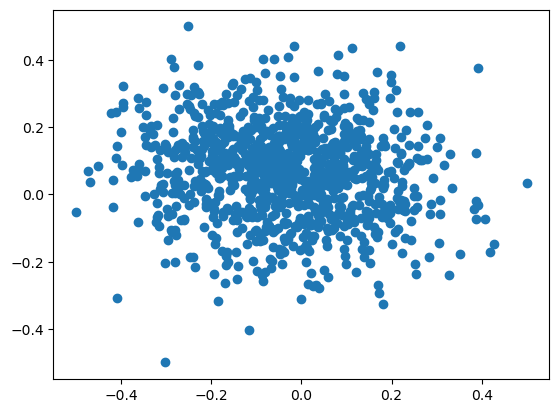

In [27]:
import matplotlib.pyplot as plt
plt.scatter(x, y)

In [28]:
onp.corrcoef(x, y, rowvar=False)

array([[ 1.   , -0.121],
       [-0.121,  1.   ]])

In [29]:
x_stdr = (x-np.mean(x))/np.std(x)
y_stdr = (y-np.mean(y))/np.std(y)
x_stdr.T@y_stdr/x_stdr.shape[0]

DeviceArray([[-0.121]], dtype=float32)

In [30]:
embedding = Isomap(n_components=10)
xy = onp.hstack([x, y])
xy_transformed = embedding.fit_transform(xy)
zc_ini = np.array(xy_transformed[:,3])[:,None]

In [31]:
hsicRBF(x, y)

DeviceArray(0.011, dtype=float32)

In [32]:
hsicRBF(zc_ini, y)

DeviceArray(0.031, dtype=float32)

In [33]:
hsicRBF(zc_ini, x)

DeviceArray(0.208, dtype=float32)

In [34]:
y.shape

(1000, 1)

In [35]:
# ix c(8, 2, 3)
# iy c(1, 7, 6)
# ic 10
Z[:,[7,1,2]]

DeviceArray([[-0.158, -0.158,  0.138],
             [ 0.108,  0.185,  0.274],
             [ 0.241,  0.233, -0.131],
             ...,
             [ 0.179,  0.083,  0.054],
             [-0.109,  0.052,  0.035],
             [-0.158, -0.066,  0.219]], dtype=float32)

In [36]:

nm = "test"

In [37]:
res = getLatentZ_wrapper(x, y, Z, U, nm, pars, num_epochs, report_freq, num_reps, batch_size, learning_rate, job)

nm: test
alpha x shape:  (1000, 7)
N:  1000
batch size:  100
batch per_epoch:  10
epochs2:  100
epochs eff:  100
num_iters:  1000
num_reports:  101
report_freq:  10
iteration:  0
iteration report:  0
monitor
{'corr_zc': DeviceArray(0.004, dtype=float32), 'hsic_indep': DeviceArray(-14.577, dtype=float32), 'hsic_resids': DeviceArray(-9.152, dtype=float32), 'hsic_rx_ax': DeviceArray(0.012, dtype=float32), 'hsic_ry_ay': DeviceArray(0.009, dtype=float32), 'hsic_x_zc': DeviceArray(0.122, dtype=float32), 'hsic_xy_zc': DeviceArray(-6.373, dtype=float32), 'hsic_y_zc': DeviceArray(0.014, dtype=float32), 'hsic_zc': DeviceArray(0.032, dtype=float32), 'hsic_zx': DeviceArray(0.165, dtype=float32), 'hsic_zx_zc': DeviceArray(0.124, dtype=float32), 'hsic_zx_zy': DeviceArray(0.015, dtype=float32), 'hsic_zy': DeviceArray(0.146, dtype=float32), 'hsic_zy_x': DeviceArray(0.01, dtype=float32), 'hsic_zy_zc': DeviceArray(0.024, dtype=float32), 'imp_zx': DeviceArray(0.074, dtype=float32), 'imp_zy': DeviceArray(

/home/emiliano/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'int'> requested in linspace is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


smpl:  [26 48 59 63]
smpl:  [ 8 11 14 24]
smpl:  [1 2 3 9]
smpl:  [ 4  8 25 26]
smpl:  [ 6 40 42 44]
smpl:  [11 25 27 33]
smpl:  [10 13 22 27]
iteration report:  10
monitor
{'corr_zc': DeviceArray(0.459, dtype=float32), 'hsic_indep': DeviceArray(-14.208, dtype=float32), 'hsic_resids': DeviceArray(-9.304, dtype=float32), 'hsic_rx_ax': DeviceArray(0.011, dtype=float32), 'hsic_ry_ay': DeviceArray(0.008, dtype=float32), 'hsic_x_zc': DeviceArray(0.011, dtype=float32), 'hsic_xy_zc': DeviceArray(-7.345, dtype=float32), 'hsic_y_zc': DeviceArray(0.058, dtype=float32), 'hsic_zc': DeviceArray(0.052, dtype=float32), 'hsic_zx': DeviceArray(0.035, dtype=float32), 'hsic_zx_zc': DeviceArray(0.02, dtype=float32), 'hsic_zx_zy': DeviceArray(0.081, dtype=float32), 'hsic_zy': DeviceArray(0.162, dtype=float32), 'hsic_zy_x': DeviceArray(0.021, dtype=float32), 'hsic_zy_zc': DeviceArray(0.019, dtype=float32), 'imp_zx': DeviceArray(0.022, dtype=float32), 'imp_zy': DeviceArray(0.021, dtype=float32), 'mse_rx': De

iteration report:  20
monitor
{'corr_zc': DeviceArray(0.091, dtype=float32), 'hsic_indep': DeviceArray(-17.578, dtype=float32), 'hsic_resids': DeviceArray(-9.713, dtype=float32), 'hsic_rx_ax': DeviceArray(0.005, dtype=float32), 'hsic_ry_ay': DeviceArray(0.011, dtype=float32), 'hsic_x_zc': DeviceArray(0.104, dtype=float32), 'hsic_xy_zc': DeviceArray(-4.639, dtype=float32), 'hsic_y_zc': DeviceArray(0.093, dtype=float32), 'hsic_zc': DeviceArray(0.024, dtype=float32), 'hsic_zx': DeviceArray(0.196, dtype=float32), 'hsic_zx_zc': DeviceArray(0.007, dtype=float32), 'hsic_zx_zy': DeviceArray(0.024, dtype=float32), 'hsic_zy': DeviceArray(0.281, dtype=float32), 'hsic_zy_x': DeviceArray(0.008, dtype=float32), 'hsic_zy_zc': DeviceArray(0.017, dtype=float32), 'imp_zx': DeviceArray(0.218, dtype=float32), 'imp_zy': DeviceArray(0.221, dtype=float32), 'mse_rx': DeviceArray(0.049, dtype=float32), 'mse_ry': DeviceArray(0.033, dtype=float32), 'mses': DeviceArray(-6.436, dtype=float32)}
indxRep: 2  iteratio

iteration report:  30
monitor
{'corr_zc': DeviceArray(0.237, dtype=float32), 'hsic_indep': DeviceArray(-17.097, dtype=float32), 'hsic_resids': DeviceArray(-9.273, dtype=float32), 'hsic_rx_ax': DeviceArray(0.009, dtype=float32), 'hsic_ry_ay': DeviceArray(0.01, dtype=float32), 'hsic_x_zc': DeviceArray(0.329, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.425, dtype=float32), 'hsic_y_zc': DeviceArray(0.099, dtype=float32), 'hsic_zc': DeviceArray(0.03, dtype=float32), 'hsic_zx': DeviceArray(0.112, dtype=float32), 'hsic_zx_zc': DeviceArray(0.037, dtype=float32), 'hsic_zx_zy': DeviceArray(0.012, dtype=float32), 'hsic_zy': DeviceArray(0.382, dtype=float32), 'hsic_zy_x': DeviceArray(0.008, dtype=float32), 'hsic_zy_zc': DeviceArray(0.011, dtype=float32), 'imp_zx': DeviceArray(0.165, dtype=float32), 'imp_zy': DeviceArray(0.173, dtype=float32), 'mse_rx': DeviceArray(0.096, dtype=float32), 'mse_ry': DeviceArray(0.058, dtype=float32), 'mses': DeviceArray(-5.188, dtype=float32)}
indxRep: 3  iteration:

{'corr_zc': DeviceArray(0.733, dtype=float32), 'hsic_indep': DeviceArray(-14.706, dtype=float32), 'hsic_resids': DeviceArray(-9.145, dtype=float32), 'hsic_rx_ax': DeviceArray(0.006, dtype=float32), 'hsic_ry_ay': DeviceArray(0.017, dtype=float32), 'hsic_x_zc': DeviceArray(0.129, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.486, dtype=float32), 'hsic_y_zc': DeviceArray(0.238, dtype=float32), 'hsic_zc': DeviceArray(0.418, dtype=float32), 'hsic_zx': DeviceArray(0.23, dtype=float32), 'hsic_zx_zc': DeviceArray(0.026, dtype=float32), 'hsic_zx_zy': DeviceArray(0.045, dtype=float32), 'hsic_zy': DeviceArray(0.228, dtype=float32), 'hsic_zy_x': DeviceArray(0.016, dtype=float32), 'hsic_zy_zc': DeviceArray(0.021, dtype=float32), 'imp_zx': DeviceArray(0.023, dtype=float32), 'imp_zy': DeviceArray(0.116, dtype=float32), 'mse_rx': DeviceArray(0.122, dtype=float32), 'mse_ry': DeviceArray(0.047, dtype=float32), 'mses': DeviceArray(-5.161, dtype=float32)}
indxRep: 4  iteration:  40  rep:  3  part:  0
itera

{'corr_zc': DeviceArray(0.825, dtype=float32), 'hsic_indep': DeviceArray(-15.683, dtype=float32), 'hsic_resids': DeviceArray(-9.308, dtype=float32), 'hsic_rx_ax': DeviceArray(0.004, dtype=float32), 'hsic_ry_ay': DeviceArray(0.022, dtype=float32), 'hsic_x_zc': DeviceArray(0.133, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.127, dtype=float32), 'hsic_y_zc': DeviceArray(0.329, dtype=float32), 'hsic_zc': DeviceArray(0.571, dtype=float32), 'hsic_zx': DeviceArray(0.473, dtype=float32), 'hsic_zx_zc': DeviceArray(0.06, dtype=float32), 'hsic_zx_zy': DeviceArray(0.004, dtype=float32), 'hsic_zy': DeviceArray(0.334, dtype=float32), 'hsic_zy_x': DeviceArray(0.024, dtype=float32), 'hsic_zy_zc': DeviceArray(0.027, dtype=float32), 'imp_zx': DeviceArray(0.03, dtype=float32), 'imp_zy': DeviceArray(0.116, dtype=float32), 'mse_rx': DeviceArray(0.067, dtype=float32), 'mse_ry': DeviceArray(0.041, dtype=float32), 'mses': DeviceArray(-5.887, dtype=float32)}
indxRep: 5  iteration:  50  rep:  4  part:  0
iterat

{'corr_zc': DeviceArray(0.808, dtype=float32), 'hsic_indep': DeviceArray(-14.077, dtype=float32), 'hsic_resids': DeviceArray(-9.344, dtype=float32), 'hsic_rx_ax': DeviceArray(0.006, dtype=float32), 'hsic_ry_ay': DeviceArray(0.015, dtype=float32), 'hsic_x_zc': DeviceArray(0.097, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.289, dtype=float32), 'hsic_y_zc': DeviceArray(0.383, dtype=float32), 'hsic_zc': DeviceArray(0.517, dtype=float32), 'hsic_zx': DeviceArray(0.506, dtype=float32), 'hsic_zx_zc': DeviceArray(0.095, dtype=float32), 'hsic_zx_zy': DeviceArray(0.009, dtype=float32), 'hsic_zy': DeviceArray(0.35, dtype=float32), 'hsic_zy_x': DeviceArray(0.026, dtype=float32), 'hsic_zy_zc': DeviceArray(0.035, dtype=float32), 'imp_zx': DeviceArray(0.221, dtype=float32), 'imp_zy': DeviceArray(0.104, dtype=float32), 'mse_rx': DeviceArray(0.087, dtype=float32), 'mse_ry': DeviceArray(0.044, dtype=float32), 'mses': DeviceArray(-5.579, dtype=float32)}
indxRep: 6  iteration:  60  rep:  5  part:  0
itera

{'corr_zc': DeviceArray(0.72, dtype=float32), 'hsic_indep': DeviceArray(-15.939, dtype=float32), 'hsic_resids': DeviceArray(-8.97, dtype=float32), 'hsic_rx_ax': DeviceArray(0.015, dtype=float32), 'hsic_ry_ay': DeviceArray(0.008, dtype=float32), 'hsic_x_zc': DeviceArray(0.042, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.98, dtype=float32), 'hsic_y_zc': DeviceArray(0.446, dtype=float32), 'hsic_zc': DeviceArray(0.397, dtype=float32), 'hsic_zx': DeviceArray(0.074, dtype=float32), 'hsic_zx_zc': DeviceArray(0.023, dtype=float32), 'hsic_zx_zy': DeviceArray(0.049, dtype=float32), 'hsic_zy': DeviceArray(0.384, dtype=float32), 'hsic_zy_x': DeviceArray(0.033, dtype=float32), 'hsic_zy_zc': DeviceArray(0.003, dtype=float32), 'imp_zx': DeviceArray(0.021, dtype=float32), 'imp_zy': DeviceArray(0.179, dtype=float32), 'mse_rx': DeviceArray(0.159, dtype=float32), 'mse_ry': DeviceArray(0.064, dtype=float32), 'mses': DeviceArray(-4.591, dtype=float32)}
indxRep: 7  iteration:  70  rep:  6  part:  0
iterati

iteration report:  90
monitor
{'corr_zc': DeviceArray(0.206, dtype=float32), 'hsic_indep': DeviceArray(-18.373, dtype=float32), 'hsic_resids': DeviceArray(-9.899, dtype=float32), 'hsic_rx_ax': DeviceArray(0.006, dtype=float32), 'hsic_ry_ay': DeviceArray(0.008, dtype=float32), 'hsic_x_zc': DeviceArray(0.207, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.883, dtype=float32), 'hsic_y_zc': DeviceArray(0.099, dtype=float32), 'hsic_zc': DeviceArray(0.031, dtype=float32), 'hsic_zx': DeviceArray(0.105, dtype=float32), 'hsic_zx_zc': DeviceArray(0.007, dtype=float32), 'hsic_zx_zy': DeviceArray(0.017, dtype=float32), 'hsic_zy': DeviceArray(0.249, dtype=float32), 'hsic_zy_x': DeviceArray(0.006, dtype=float32), 'hsic_zy_zc': DeviceArray(0.015, dtype=float32), 'imp_zx': DeviceArray(0.18, dtype=float32), 'imp_zy': DeviceArray(0.185, dtype=float32), 'mse_rx': DeviceArray(0.052, dtype=float32), 'mse_ry': DeviceArray(0.041, dtype=float32), 'mses': DeviceArray(-6.143, dtype=float32)}
indxRep: 9  iteration

iteration report:  100
monitor
{'corr_zc': DeviceArray(0.164, dtype=float32), 'hsic_indep': DeviceArray(-17.858, dtype=float32), 'hsic_resids': DeviceArray(-9.749, dtype=float32), 'hsic_rx_ax': DeviceArray(0.005, dtype=float32), 'hsic_ry_ay': DeviceArray(0.011, dtype=float32), 'hsic_x_zc': DeviceArray(0.129, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.008, dtype=float32), 'hsic_y_zc': DeviceArray(0.383, dtype=float32), 'hsic_zc': DeviceArray(0.02, dtype=float32), 'hsic_zx': DeviceArray(0.161, dtype=float32), 'hsic_zx_zc': DeviceArray(0.007, dtype=float32), 'hsic_zx_zy': DeviceArray(0.015, dtype=float32), 'hsic_zy': DeviceArray(0.339, dtype=float32), 'hsic_zy_x': DeviceArray(0.006, dtype=float32), 'hsic_zy_zc': DeviceArray(0.027, dtype=float32), 'imp_zx': DeviceArray(0.38, dtype=float32), 'imp_zy': DeviceArray(0.057, dtype=float32), 'mse_rx': DeviceArray(0.08, dtype=float32), 'mse_ry': DeviceArray(0.054, dtype=float32), 'mses': DeviceArray(-5.439, dtype=float32)}
indxRep: 10  iteration

iteration report:  110
monitor
{'corr_zc': DeviceArray(0.766, dtype=float32), 'hsic_indep': DeviceArray(-18.307, dtype=float32), 'hsic_resids': DeviceArray(-8.89, dtype=float32), 'hsic_rx_ax': DeviceArray(0.009, dtype=float32), 'hsic_ry_ay': DeviceArray(0.015, dtype=float32), 'hsic_x_zc': DeviceArray(0.178, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.33, dtype=float32), 'hsic_y_zc': DeviceArray(0.201, dtype=float32), 'hsic_zc': DeviceArray(0.461, dtype=float32), 'hsic_zx': DeviceArray(0.353, dtype=float32), 'hsic_zx_zc': DeviceArray(0.016, dtype=float32), 'hsic_zx_zy': DeviceArray(0.009, dtype=float32), 'hsic_zy': DeviceArray(0.236, dtype=float32), 'hsic_zy_x': DeviceArray(0.008, dtype=float32), 'hsic_zy_zc': DeviceArray(0.009, dtype=float32), 'imp_zx': DeviceArray(0.023, dtype=float32), 'imp_zy': DeviceArray(0.157, dtype=float32), 'mse_rx': DeviceArray(0.117, dtype=float32), 'mse_ry': DeviceArray(0.045, dtype=float32), 'mses': DeviceArray(-5.244, dtype=float32)}
indxRep: 11  iteratio

iteration report:  120
monitor
{'corr_zc': DeviceArray(0.761, dtype=float32), 'hsic_indep': DeviceArray(-18.755, dtype=float32), 'hsic_resids': DeviceArray(-9.304, dtype=float32), 'hsic_rx_ax': DeviceArray(0.005, dtype=float32), 'hsic_ry_ay': DeviceArray(0.018, dtype=float32), 'hsic_x_zc': DeviceArray(0.173, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.229, dtype=float32), 'hsic_y_zc': DeviceArray(0.229, dtype=float32), 'hsic_zc': DeviceArray(0.482, dtype=float32), 'hsic_zx': DeviceArray(0.584, dtype=float32), 'hsic_zx_zc': DeviceArray(0.015, dtype=float32), 'hsic_zx_zy': DeviceArray(0.005, dtype=float32), 'hsic_zy': DeviceArray(0.273, dtype=float32), 'hsic_zy_x': DeviceArray(0.019, dtype=float32), 'hsic_zy_zc': DeviceArray(0.006, dtype=float32), 'imp_zx': DeviceArray(0.069, dtype=float32), 'imp_zy': DeviceArray(0.136, dtype=float32), 'mse_rx': DeviceArray(0.065, dtype=float32), 'mse_ry': DeviceArray(0.038, dtype=float32), 'mses': DeviceArray(-5.997, dtype=float32)}
indxRep: 12  iterat

iteration report:  130
monitor
{'corr_zc': DeviceArray(0.811, dtype=float32), 'hsic_indep': DeviceArray(-19.091, dtype=float32), 'hsic_resids': DeviceArray(-9.109, dtype=float32), 'hsic_rx_ax': DeviceArray(0.005, dtype=float32), 'hsic_ry_ay': DeviceArray(0.021, dtype=float32), 'hsic_x_zc': DeviceArray(0.14, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.291, dtype=float32), 'hsic_y_zc': DeviceArray(0.266, dtype=float32), 'hsic_zc': DeviceArray(0.529, dtype=float32), 'hsic_zx': DeviceArray(0.525, dtype=float32), 'hsic_zx_zc': DeviceArray(0.003, dtype=float32), 'hsic_zx_zy': DeviceArray(0.005, dtype=float32), 'hsic_zy': DeviceArray(0.389, dtype=float32), 'hsic_zy_x': DeviceArray(0.025, dtype=float32), 'hsic_zy_zc': DeviceArray(0.013, dtype=float32), 'imp_zx': DeviceArray(0.065, dtype=float32), 'imp_zy': DeviceArray(0.064, dtype=float32), 'mse_rx': DeviceArray(0.085, dtype=float32), 'mse_ry': DeviceArray(0.045, dtype=float32), 'mses': DeviceArray(-5.575, dtype=float32)}
indxRep: 13  iterati

iteration report:  140
monitor
{'corr_zc': DeviceArray(0.753, dtype=float32), 'hsic_indep': DeviceArray(-22.466, dtype=float32), 'hsic_resids': DeviceArray(-8.417, dtype=float32), 'hsic_rx_ax': DeviceArray(0.024, dtype=float32), 'hsic_ry_ay': DeviceArray(0.009, dtype=float32), 'hsic_x_zc': DeviceArray(0.069, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.563, dtype=float32), 'hsic_y_zc': DeviceArray(0.412, dtype=float32), 'hsic_zc': DeviceArray(0.426, dtype=float32), 'hsic_zx': DeviceArray(0.107, dtype=float32), 'hsic_zx_zc': DeviceArray(0.001, dtype=float32), 'hsic_zx_zy': DeviceArray(0.001, dtype=float32), 'hsic_zy': DeviceArray(0.372, dtype=float32), 'hsic_zy_x': DeviceArray(0.011, dtype=float32), 'hsic_zy_zc': DeviceArray(0.029, dtype=float32), 'imp_zx': DeviceArray(0.04, dtype=float32), 'imp_zy': DeviceArray(0.081, dtype=float32), 'mse_rx': DeviceArray(0.154, dtype=float32), 'mse_ry': DeviceArray(0.063, dtype=float32), 'mses': DeviceArray(-4.628, dtype=float32)}
indxRep: 14  iterati

iteration report:  160
monitor
{'corr_zc': DeviceArray(0.543, dtype=float32), 'hsic_indep': DeviceArray(-16.43, dtype=float32), 'hsic_resids': DeviceArray(-9.378, dtype=float32), 'hsic_rx_ax': DeviceArray(0.008, dtype=float32), 'hsic_ry_ay': DeviceArray(0.011, dtype=float32), 'hsic_x_zc': DeviceArray(0.009, dtype=float32), 'hsic_xy_zc': DeviceArray(-6.932, dtype=float32), 'hsic_y_zc': DeviceArray(0.103, dtype=float32), 'hsic_zc': DeviceArray(0.067, dtype=float32), 'hsic_zx': DeviceArray(0.202, dtype=float32), 'hsic_zx_zc': DeviceArray(0.019, dtype=float32), 'hsic_zx_zy': DeviceArray(0.019, dtype=float32), 'hsic_zy': DeviceArray(0.194, dtype=float32), 'hsic_zy_x': DeviceArray(0.01, dtype=float32), 'hsic_zy_zc': DeviceArray(0.019, dtype=float32), 'imp_zx': DeviceArray(0.059, dtype=float32), 'imp_zy': DeviceArray(0.012, dtype=float32), 'mse_rx': DeviceArray(0.083, dtype=float32), 'mse_ry': DeviceArray(0.097, dtype=float32), 'mses': DeviceArray(-4.822, dtype=float32)}
indxRep: 16  iteratio

iteration report:  170
monitor
{'corr_zc': DeviceArray(0.201, dtype=float32), 'hsic_indep': DeviceArray(-18.402, dtype=float32), 'hsic_resids': DeviceArray(-9.112, dtype=float32), 'hsic_rx_ax': DeviceArray(0.009, dtype=float32), 'hsic_ry_ay': DeviceArray(0.012, dtype=float32), 'hsic_x_zc': DeviceArray(0.273, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.353, dtype=float32), 'hsic_y_zc': DeviceArray(0.128, dtype=float32), 'hsic_zc': DeviceArray(0.026, dtype=float32), 'hsic_zx': DeviceArray(0.117, dtype=float32), 'hsic_zx_zc': DeviceArray(0.009, dtype=float32), 'hsic_zx_zy': DeviceArray(0.009, dtype=float32), 'hsic_zy': DeviceArray(0.315, dtype=float32), 'hsic_zy_x': DeviceArray(0.008, dtype=float32), 'hsic_zy_zc': DeviceArray(0.016, dtype=float32), 'imp_zx': DeviceArray(0.191, dtype=float32), 'imp_zy': DeviceArray(0.113, dtype=float32), 'mse_rx': DeviceArray(0.063, dtype=float32), 'mse_ry': DeviceArray(0.057, dtype=float32), 'mses': DeviceArray(-5.627, dtype=float32)}
indxRep: 17  iterat

iteration report:  180
monitor
{'corr_zc': DeviceArray(0.064, dtype=float32), 'hsic_indep': DeviceArray(-19.857, dtype=float32), 'hsic_resids': DeviceArray(-10.052, dtype=float32), 'hsic_rx_ax': DeviceArray(0.004, dtype=float32), 'hsic_ry_ay': DeviceArray(0.01, dtype=float32), 'hsic_x_zc': DeviceArray(0.254, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.975, dtype=float32), 'hsic_y_zc': DeviceArray(0.201, dtype=float32), 'hsic_zc': DeviceArray(0.012, dtype=float32), 'hsic_zx': DeviceArray(0.155, dtype=float32), 'hsic_zx_zc': DeviceArray(0.004, dtype=float32), 'hsic_zx_zy': DeviceArray(0.014, dtype=float32), 'hsic_zy': DeviceArray(0.246, dtype=float32), 'hsic_zy_x': DeviceArray(0.005, dtype=float32), 'hsic_zy_zc': DeviceArray(0.009, dtype=float32), 'imp_zx': DeviceArray(0.51, dtype=float32), 'imp_zy': DeviceArray(0.121, dtype=float32), 'mse_rx': DeviceArray(0.057, dtype=float32), 'mse_ry': DeviceArray(0.053, dtype=float32), 'mses': DeviceArray(-5.804, dtype=float32)}
indxRep: 18  iterati

iteration report:  190
monitor
{'corr_zc': DeviceArray(0.733, dtype=float32), 'hsic_indep': DeviceArray(-18.199, dtype=float32), 'hsic_resids': DeviceArray(-9.116, dtype=float32), 'hsic_rx_ax': DeviceArray(0.009, dtype=float32), 'hsic_ry_ay': DeviceArray(0.013, dtype=float32), 'hsic_x_zc': DeviceArray(0.215, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.42, dtype=float32), 'hsic_y_zc': DeviceArray(0.152, dtype=float32), 'hsic_zc': DeviceArray(0.418, dtype=float32), 'hsic_zx': DeviceArray(0.372, dtype=float32), 'hsic_zx_zc': DeviceArray(0.008, dtype=float32), 'hsic_zx_zy': DeviceArray(0.017, dtype=float32), 'hsic_zy': DeviceArray(0.276, dtype=float32), 'hsic_zy_x': DeviceArray(0.005, dtype=float32), 'hsic_zy_zc': DeviceArray(0.019, dtype=float32), 'imp_zx': DeviceArray(0.02, dtype=float32), 'imp_zy': DeviceArray(0.197, dtype=float32), 'mse_rx': DeviceArray(0.101, dtype=float32), 'mse_ry': DeviceArray(0.042, dtype=float32), 'mses': DeviceArray(-5.47, dtype=float32)}
indxRep: 19  iteration

iteration report:  200
monitor
{'corr_zc': DeviceArray(0.764, dtype=float32), 'hsic_indep': DeviceArray(-20.075, dtype=float32), 'hsic_resids': DeviceArray(-9.405, dtype=float32), 'hsic_rx_ax': DeviceArray(0.005, dtype=float32), 'hsic_ry_ay': DeviceArray(0.015, dtype=float32), 'hsic_x_zc': DeviceArray(0.165, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.19, dtype=float32), 'hsic_y_zc': DeviceArray(0.25, dtype=float32), 'hsic_zc': DeviceArray(0.476, dtype=float32), 'hsic_zx': DeviceArray(0.537, dtype=float32), 'hsic_zx_zc': DeviceArray(0.003, dtype=float32), 'hsic_zx_zy': DeviceArray(0.007, dtype=float32), 'hsic_zy': DeviceArray(0.273, dtype=float32), 'hsic_zy_x': DeviceArray(0.012, dtype=float32), 'hsic_zy_zc': DeviceArray(0.008, dtype=float32), 'imp_zx': DeviceArray(0.042, dtype=float32), 'imp_zy': DeviceArray(0.153, dtype=float32), 'mse_rx': DeviceArray(0.065, dtype=float32), 'mse_ry': DeviceArray(0.037, dtype=float32), 'mses': DeviceArray(-6.037, dtype=float32)}
indxRep: 20  iteratio

iteration report:  210
monitor
{'corr_zc': DeviceArray(0.81, dtype=float32), 'hsic_indep': DeviceArray(-20.515, dtype=float32), 'hsic_resids': DeviceArray(-9.354, dtype=float32), 'hsic_rx_ax': DeviceArray(0.004, dtype=float32), 'hsic_ry_ay': DeviceArray(0.02, dtype=float32), 'hsic_x_zc': DeviceArray(0.18, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.242, dtype=float32), 'hsic_y_zc': DeviceArray(0.216, dtype=float32), 'hsic_zc': DeviceArray(0.526, dtype=float32), 'hsic_zx': DeviceArray(0.549, dtype=float32), 'hsic_zx_zc': DeviceArray(0.034, dtype=float32), 'hsic_zx_zy': DeviceArray(0.001, dtype=float32), 'hsic_zy': DeviceArray(0.458, dtype=float32), 'hsic_zy_x': DeviceArray(0.016, dtype=float32), 'hsic_zy_zc': DeviceArray(0.002, dtype=float32), 'imp_zx': DeviceArray(0.077, dtype=float32), 'imp_zy': DeviceArray(0.078, dtype=float32), 'mse_rx': DeviceArray(0.083, dtype=float32), 'mse_ry': DeviceArray(0.045, dtype=float32), 'mses': DeviceArray(-5.586, dtype=float32)}
indxRep: 21  iteration

iteration report:  220
monitor
{'corr_zc': DeviceArray(0.801, dtype=float32), 'hsic_indep': DeviceArray(-17.55, dtype=float32), 'hsic_resids': DeviceArray(-8.269, dtype=float32), 'hsic_rx_ax': DeviceArray(0.025, dtype=float32), 'hsic_ry_ay': DeviceArray(0.01, dtype=float32), 'hsic_x_zc': DeviceArray(0.096, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.292, dtype=float32), 'hsic_y_zc': DeviceArray(0.387, dtype=float32), 'hsic_zc': DeviceArray(0.475, dtype=float32), 'hsic_zx': DeviceArray(0.111, dtype=float32), 'hsic_zx_zc': DeviceArray(0.023, dtype=float32), 'hsic_zx_zy': DeviceArray(0.025, dtype=float32), 'hsic_zy': DeviceArray(0.381, dtype=float32), 'hsic_zy_x': DeviceArray(0.007, dtype=float32), 'hsic_zy_zc': DeviceArray(0.006, dtype=float32), 'imp_zx': DeviceArray(0.045, dtype=float32), 'imp_zy': DeviceArray(0.069, dtype=float32), 'mse_rx': DeviceArray(0.151, dtype=float32), 'mse_ry': DeviceArray(0.067, dtype=float32), 'mses': DeviceArray(-4.598, dtype=float32)}
indxRep: 22  iteratio

iteration report:  240
monitor
{'corr_zc': DeviceArray(0.618, dtype=float32), 'hsic_indep': DeviceArray(-15.712, dtype=float32), 'hsic_resids': DeviceArray(-9.276, dtype=float32), 'hsic_rx_ax': DeviceArray(0.007, dtype=float32), 'hsic_ry_ay': DeviceArray(0.013, dtype=float32), 'hsic_x_zc': DeviceArray(0.012, dtype=float32), 'hsic_xy_zc': DeviceArray(-6.507, dtype=float32), 'hsic_y_zc': DeviceArray(0.127, dtype=float32), 'hsic_zc': DeviceArray(0.09, dtype=float32), 'hsic_zx': DeviceArray(0.223, dtype=float32), 'hsic_zx_zc': DeviceArray(0.018, dtype=float32), 'hsic_zx_zy': DeviceArray(0.024, dtype=float32), 'hsic_zy': DeviceArray(0.219, dtype=float32), 'hsic_zy_x': DeviceArray(0.016, dtype=float32), 'hsic_zy_zc': DeviceArray(0.022, dtype=float32), 'imp_zx': DeviceArray(0.037, dtype=float32), 'imp_zy': DeviceArray(0.032, dtype=float32), 'mse_rx': DeviceArray(0.068, dtype=float32), 'mse_ry': DeviceArray(0.091, dtype=float32), 'mses': DeviceArray(-5.095, dtype=float32)}
indxRep: 24  iterati

iteration report:  250
monitor
{'corr_zc': DeviceArray(0.004, dtype=float32), 'hsic_indep': DeviceArray(-18.84, dtype=float32), 'hsic_resids': DeviceArray(-10.184, dtype=float32), 'hsic_rx_ax': DeviceArray(0.006, dtype=float32), 'hsic_ry_ay': DeviceArray(0.007, dtype=float32), 'hsic_x_zc': DeviceArray(0.156, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.595, dtype=float32), 'hsic_y_zc': DeviceArray(0.176, dtype=float32), 'hsic_zc': DeviceArray(0.018, dtype=float32), 'hsic_zx': DeviceArray(0.165, dtype=float32), 'hsic_zx_zc': DeviceArray(0.008, dtype=float32), 'hsic_zx_zy': DeviceArray(0.011, dtype=float32), 'hsic_zy': DeviceArray(0.276, dtype=float32), 'hsic_zy_x': DeviceArray(0.007, dtype=float32), 'hsic_zy_zc': DeviceArray(0.011, dtype=float32), 'imp_zx': DeviceArray(0.391, dtype=float32), 'imp_zy': DeviceArray(0.13, dtype=float32), 'mse_rx': DeviceArray(0.055, dtype=float32), 'mse_ry': DeviceArray(0.038, dtype=float32), 'mses': DeviceArray(-6.166, dtype=float32)}
indxRep: 25  iterati

iteration report:  260
monitor
{'corr_zc': DeviceArray(0.043, dtype=float32), 'hsic_indep': DeviceArray(-20.052, dtype=float32), 'hsic_resids': DeviceArray(-8.345, dtype=float32), 'hsic_rx_ax': DeviceArray(0.015, dtype=float32), 'hsic_ry_ay': DeviceArray(0.016, dtype=float32), 'hsic_x_zc': DeviceArray(0.205, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.819, dtype=float32), 'hsic_y_zc': DeviceArray(0.291, dtype=float32), 'hsic_zc': DeviceArray(0.012, dtype=float32), 'hsic_zx': DeviceArray(0.126, dtype=float32), 'hsic_zx_zc': DeviceArray(0.013, dtype=float32), 'hsic_zx_zy': DeviceArray(0.004, dtype=float32), 'hsic_zy': DeviceArray(0.241, dtype=float32), 'hsic_zy_x': DeviceArray(0.005, dtype=float32), 'hsic_zy_zc': DeviceArray(0.008, dtype=float32), 'imp_zx': DeviceArray(0.4, dtype=float32), 'imp_zy': DeviceArray(0.055, dtype=float32), 'mse_rx': DeviceArray(0.063, dtype=float32), 'mse_ry': DeviceArray(0.058, dtype=float32), 'mses': DeviceArray(-5.612, dtype=float32)}
indxRep: 26  iteratio

iteration report:  270
monitor
{'corr_zc': DeviceArray(0.741, dtype=float32), 'hsic_indep': DeviceArray(-20.439, dtype=float32), 'hsic_resids': DeviceArray(-8.73, dtype=float32), 'hsic_rx_ax': DeviceArray(0.013, dtype=float32), 'hsic_ry_ay': DeviceArray(0.013, dtype=float32), 'hsic_x_zc': DeviceArray(0.231, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.414, dtype=float32), 'hsic_y_zc': DeviceArray(0.143, dtype=float32), 'hsic_zc': DeviceArray(0.429, dtype=float32), 'hsic_zx': DeviceArray(0.425, dtype=float32), 'hsic_zx_zc': DeviceArray(0.009, dtype=float32), 'hsic_zx_zy': DeviceArray(0.004, dtype=float32), 'hsic_zy': DeviceArray(0.272, dtype=float32), 'hsic_zy_x': DeviceArray(0.006, dtype=float32), 'hsic_zy_zc': DeviceArray(0.006, dtype=float32), 'imp_zx': DeviceArray(0.017, dtype=float32), 'imp_zy': DeviceArray(0.173, dtype=float32), 'mse_rx': DeviceArray(0.104, dtype=float32), 'mse_ry': DeviceArray(0.044, dtype=float32), 'mses': DeviceArray(-5.381, dtype=float32)}
indxRep: 27  iterati

iteration report:  280
monitor
{'corr_zc': DeviceArray(0.773, dtype=float32), 'hsic_indep': DeviceArray(-20.513, dtype=float32), 'hsic_resids': DeviceArray(-9.296, dtype=float32), 'hsic_rx_ax': DeviceArray(0.006, dtype=float32), 'hsic_ry_ay': DeviceArray(0.016, dtype=float32), 'hsic_x_zc': DeviceArray(0.179, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.184, dtype=float32), 'hsic_y_zc': DeviceArray(0.232, dtype=float32), 'hsic_zc': DeviceArray(0.489, dtype=float32), 'hsic_zx': DeviceArray(0.467, dtype=float32), 'hsic_zx_zc': DeviceArray(0.003, dtype=float32), 'hsic_zx_zy': DeviceArray(0.003, dtype=float32), 'hsic_zy': DeviceArray(0.318, dtype=float32), 'hsic_zy_x': DeviceArray(0.008, dtype=float32), 'hsic_zy_zc': DeviceArray(0.017, dtype=float32), 'imp_zx': DeviceArray(0.054, dtype=float32), 'imp_zy': DeviceArray(0.17, dtype=float32), 'mse_rx': DeviceArray(0.065, dtype=float32), 'mse_ry': DeviceArray(0.038, dtype=float32), 'mses': DeviceArray(-6.02, dtype=float32)}
indxRep: 28  iteratio

iteration report:  290
monitor
{'corr_zc': DeviceArray(0.796, dtype=float32), 'hsic_indep': DeviceArray(-19.773, dtype=float32), 'hsic_resids': DeviceArray(-9.153, dtype=float32), 'hsic_rx_ax': DeviceArray(0.006, dtype=float32), 'hsic_ry_ay': DeviceArray(0.019, dtype=float32), 'hsic_x_zc': DeviceArray(0.162, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.403, dtype=float32), 'hsic_y_zc': DeviceArray(0.205, dtype=float32), 'hsic_zc': DeviceArray(0.514, dtype=float32), 'hsic_zx': DeviceArray(0.525, dtype=float32), 'hsic_zx_zc': DeviceArray(0.001, dtype=float32), 'hsic_zx_zy': DeviceArray(0.012, dtype=float32), 'hsic_zy': DeviceArray(0.479, dtype=float32), 'hsic_zy_x': DeviceArray(0.014, dtype=float32), 'hsic_zy_zc': DeviceArray(0.015, dtype=float32), 'imp_zx': DeviceArray(0.055, dtype=float32), 'imp_zy': DeviceArray(0.068, dtype=float32), 'mse_rx': DeviceArray(0.082, dtype=float32), 'mse_ry': DeviceArray(0.044, dtype=float32), 'mses': DeviceArray(-5.64, dtype=float32)}
indxRep: 29  iterati

iteration report:  300
monitor
{'corr_zc': DeviceArray(0.851, dtype=float32), 'hsic_indep': DeviceArray(-16.842, dtype=float32), 'hsic_resids': DeviceArray(-8.423, dtype=float32), 'hsic_rx_ax': DeviceArray(0.022, dtype=float32), 'hsic_ry_ay': DeviceArray(0.01, dtype=float32), 'hsic_x_zc': DeviceArray(0.125, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.067, dtype=float32), 'hsic_y_zc': DeviceArray(0.373, dtype=float32), 'hsic_zc': DeviceArray(0.52, dtype=float32), 'hsic_zx': DeviceArray(0.106, dtype=float32), 'hsic_zx_zc': DeviceArray(0.006, dtype=float32), 'hsic_zx_zy': DeviceArray(0.025, dtype=float32), 'hsic_zy': DeviceArray(0.368, dtype=float32), 'hsic_zy_x': DeviceArray(0.01, dtype=float32), 'hsic_zy_zc': DeviceArray(0.031, dtype=float32), 'imp_zx': DeviceArray(0.057, dtype=float32), 'imp_zy': DeviceArray(0.126, dtype=float32), 'mse_rx': DeviceArray(0.147, dtype=float32), 'mse_ry': DeviceArray(0.063, dtype=float32), 'mses': DeviceArray(-4.687, dtype=float32)}
indxRep: 30  iteration

iteration report:  320
monitor
{'corr_zc': DeviceArray(0.647, dtype=float32), 'hsic_indep': DeviceArray(-16.531, dtype=float32), 'hsic_resids': DeviceArray(-9.026, dtype=float32), 'hsic_rx_ax': DeviceArray(0.01, dtype=float32), 'hsic_ry_ay': DeviceArray(0.012, dtype=float32), 'hsic_x_zc': DeviceArray(0.01, dtype=float32), 'hsic_xy_zc': DeviceArray(-6.6, dtype=float32), 'hsic_y_zc': DeviceArray(0.142, dtype=float32), 'hsic_zc': DeviceArray(0.1, dtype=float32), 'hsic_zx': DeviceArray(0.263, dtype=float32), 'hsic_zx_zc': DeviceArray(0.019, dtype=float32), 'hsic_zx_zy': DeviceArray(0.017, dtype=float32), 'hsic_zy': DeviceArray(0.167, dtype=float32), 'hsic_zy_x': DeviceArray(0.01, dtype=float32), 'hsic_zy_zc': DeviceArray(0.021, dtype=float32), 'imp_zx': DeviceArray(0.015, dtype=float32), 'imp_zy': DeviceArray(0.017, dtype=float32), 'mse_rx': DeviceArray(0.069, dtype=float32), 'mse_ry': DeviceArray(0.086, dtype=float32), 'mses': DeviceArray(-5.118, dtype=float32)}
indxRep: 32  iteration:  3

iteration report:  330
monitor
{'corr_zc': DeviceArray(0.023, dtype=float32), 'hsic_indep': DeviceArray(-18.682, dtype=float32), 'hsic_resids': DeviceArray(-10.273, dtype=float32), 'hsic_rx_ax': DeviceArray(0.005, dtype=float32), 'hsic_ry_ay': DeviceArray(0.007, dtype=float32), 'hsic_x_zc': DeviceArray(0.173, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.484, dtype=float32), 'hsic_y_zc': DeviceArray(0.178, dtype=float32), 'hsic_zc': DeviceArray(0.024, dtype=float32), 'hsic_zx': DeviceArray(0.187, dtype=float32), 'hsic_zx_zc': DeviceArray(0.007, dtype=float32), 'hsic_zx_zy': DeviceArray(0.012, dtype=float32), 'hsic_zy': DeviceArray(0.202, dtype=float32), 'hsic_zy_x': DeviceArray(0.013, dtype=float32), 'hsic_zy_zc': DeviceArray(0.007, dtype=float32), 'imp_zx': DeviceArray(0.264, dtype=float32), 'imp_zy': DeviceArray(0.184, dtype=float32), 'mse_rx': DeviceArray(0.054, dtype=float32), 'mse_ry': DeviceArray(0.037, dtype=float32), 'mses': DeviceArray(-6.209, dtype=float32)}
indxRep: 33  itera

iteration report:  340
monitor
{'corr_zc': DeviceArray(0.092, dtype=float32), 'hsic_indep': DeviceArray(-22.223, dtype=float32), 'hsic_resids': DeviceArray(-9.278, dtype=float32), 'hsic_rx_ax': DeviceArray(0.006, dtype=float32), 'hsic_ry_ay': DeviceArray(0.015, dtype=float32), 'hsic_x_zc': DeviceArray(0.294, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.831, dtype=float32), 'hsic_y_zc': DeviceArray(0.201, dtype=float32), 'hsic_zc': DeviceArray(0.013, dtype=float32), 'hsic_zx': DeviceArray(0.177, dtype=float32), 'hsic_zx_zc': DeviceArray(0.007, dtype=float32), 'hsic_zx_zy': DeviceArray(0.003, dtype=float32), 'hsic_zy': DeviceArray(0.166, dtype=float32), 'hsic_zy_x': DeviceArray(0.004, dtype=float32), 'hsic_zy_zc': DeviceArray(0.003, dtype=float32), 'imp_zx': DeviceArray(0.559, dtype=float32), 'imp_zy': DeviceArray(0.044, dtype=float32), 'mse_rx': DeviceArray(0.057, dtype=float32), 'mse_ry': DeviceArray(0.071, dtype=float32), 'mses': DeviceArray(-5.516, dtype=float32)}
indxRep: 34  iterat

iteration report:  350
monitor
{'corr_zc': DeviceArray(0.711, dtype=float32), 'hsic_indep': DeviceArray(-20.334, dtype=float32), 'hsic_resids': DeviceArray(-8.817, dtype=float32), 'hsic_rx_ax': DeviceArray(0.013, dtype=float32), 'hsic_ry_ay': DeviceArray(0.012, dtype=float32), 'hsic_x_zc': DeviceArray(0.193, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.433, dtype=float32), 'hsic_y_zc': DeviceArray(0.167, dtype=float32), 'hsic_zc': DeviceArray(0.38, dtype=float32), 'hsic_zx': DeviceArray(0.408, dtype=float32), 'hsic_zx_zc': DeviceArray(0.008, dtype=float32), 'hsic_zx_zy': DeviceArray(0.006, dtype=float32), 'hsic_zy': DeviceArray(0.277, dtype=float32), 'hsic_zy_x': DeviceArray(0.004, dtype=float32), 'hsic_zy_zc': DeviceArray(0.006, dtype=float32), 'imp_zx': DeviceArray(0.013, dtype=float32), 'imp_zy': DeviceArray(0.138, dtype=float32), 'mse_rx': DeviceArray(0.105, dtype=float32), 'mse_ry': DeviceArray(0.044, dtype=float32), 'mses': DeviceArray(-5.388, dtype=float32)}
indxRep: 35  iterati

iteration report:  360
monitor
{'corr_zc': DeviceArray(0.693, dtype=float32), 'hsic_indep': DeviceArray(-18.627, dtype=float32), 'hsic_resids': DeviceArray(-9.217, dtype=float32), 'hsic_rx_ax': DeviceArray(0.007, dtype=float32), 'hsic_ry_ay': DeviceArray(0.015, dtype=float32), 'hsic_x_zc': DeviceArray(0.166, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.4, dtype=float32), 'hsic_y_zc': DeviceArray(0.201, dtype=float32), 'hsic_zc': DeviceArray(0.395, dtype=float32), 'hsic_zx': DeviceArray(0.379, dtype=float32), 'hsic_zx_zc': DeviceArray(0.053, dtype=float32), 'hsic_zx_zy': DeviceArray(0.006, dtype=float32), 'hsic_zy': DeviceArray(0.256, dtype=float32), 'hsic_zy_x': DeviceArray(0.006, dtype=float32), 'hsic_zy_zc': DeviceArray(0.004, dtype=float32), 'imp_zx': DeviceArray(0.035, dtype=float32), 'imp_zy': DeviceArray(0.166, dtype=float32), 'mse_rx': DeviceArray(0.062, dtype=float32), 'mse_ry': DeviceArray(0.036, dtype=float32), 'mses': DeviceArray(-6.112, dtype=float32)}
indxRep: 36  iteratio

iteration report:  370
monitor
{'corr_zc': DeviceArray(0.854, dtype=float32), 'hsic_indep': DeviceArray(-19.061, dtype=float32), 'hsic_resids': DeviceArray(-9.247, dtype=float32), 'hsic_rx_ax': DeviceArray(0.004, dtype=float32), 'hsic_ry_ay': DeviceArray(0.022, dtype=float32), 'hsic_x_zc': DeviceArray(0.178, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.116, dtype=float32), 'hsic_y_zc': DeviceArray(0.25, dtype=float32), 'hsic_zc': DeviceArray(0.579, dtype=float32), 'hsic_zx': DeviceArray(0.539, dtype=float32), 'hsic_zx_zc': DeviceArray(0.012, dtype=float32), 'hsic_zx_zy': DeviceArray(0.005, dtype=float32), 'hsic_zy': DeviceArray(0.559, dtype=float32), 'hsic_zy_x': DeviceArray(0.008, dtype=float32), 'hsic_zy_zc': DeviceArray(0.011, dtype=float32), 'imp_zx': DeviceArray(0.021, dtype=float32), 'imp_zy': DeviceArray(0.059, dtype=float32), 'mse_rx': DeviceArray(0.078, dtype=float32), 'mse_ry': DeviceArray(0.048, dtype=float32), 'mses': DeviceArray(-5.576, dtype=float32)}
indxRep: 37  iterati

iteration report:  380
monitor
{'corr_zc': DeviceArray(0.834, dtype=float32), 'hsic_indep': DeviceArray(-23.58, dtype=float32), 'hsic_resids': DeviceArray(-8.278, dtype=float32), 'hsic_rx_ax': DeviceArray(0.024, dtype=float32), 'hsic_ry_ay': DeviceArray(0.011, dtype=float32), 'hsic_x_zc': DeviceArray(0.127, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.067, dtype=float32), 'hsic_y_zc': DeviceArray(0.365, dtype=float32), 'hsic_zc': DeviceArray(0.5, dtype=float32), 'hsic_zx': DeviceArray(0.107, dtype=float32), 'hsic_zx_zc': DeviceArray(0.002, dtype=float32), 'hsic_zx_zy': DeviceArray(0.012, dtype=float32), 'hsic_zy': DeviceArray(0.382, dtype=float32), 'hsic_zy_x': DeviceArray(0.006, dtype=float32), 'hsic_zy_zc': DeviceArray(0., dtype=float32), 'imp_zx': DeviceArray(0.06, dtype=float32), 'imp_zy': DeviceArray(0.092, dtype=float32), 'mse_rx': DeviceArray(0.146, dtype=float32), 'mse_ry': DeviceArray(0.063, dtype=float32), 'mses': DeviceArray(-4.687, dtype=float32)}
indxRep: 38  iteration:  3

iteration:  400
iteration report:  400
monitor
{'corr_zc': DeviceArray(0.687, dtype=float32), 'hsic_indep': DeviceArray(-16.462, dtype=float32), 'hsic_resids': DeviceArray(-9.191, dtype=float32), 'hsic_rx_ax': DeviceArray(0.008, dtype=float32), 'hsic_ry_ay': DeviceArray(0.013, dtype=float32), 'hsic_x_zc': DeviceArray(0.009, dtype=float32), 'hsic_xy_zc': DeviceArray(-6.436, dtype=float32), 'hsic_y_zc': DeviceArray(0.177, dtype=float32), 'hsic_zc': DeviceArray(0.116, dtype=float32), 'hsic_zx': DeviceArray(0.214, dtype=float32), 'hsic_zx_zc': DeviceArray(0.019, dtype=float32), 'hsic_zx_zy': DeviceArray(0.018, dtype=float32), 'hsic_zy': DeviceArray(0.237, dtype=float32), 'hsic_zy_x': DeviceArray(0.009, dtype=float32), 'hsic_zy_zc': DeviceArray(0.024, dtype=float32), 'imp_zx': DeviceArray(0.082, dtype=float32), 'imp_zy': DeviceArray(0.011, dtype=float32), 'mse_rx': DeviceArray(0.062, dtype=float32), 'mse_ry': DeviceArray(0.077, dtype=float32), 'mses': DeviceArray(-5.349, dtype=float32)}
ind

iteration report:  410
monitor
{'corr_zc': DeviceArray(0.106, dtype=float32), 'hsic_indep': DeviceArray(-20.079, dtype=float32), 'hsic_resids': DeviceArray(-8.731, dtype=float32), 'hsic_rx_ax': DeviceArray(0.014, dtype=float32), 'hsic_ry_ay': DeviceArray(0.012, dtype=float32), 'hsic_x_zc': DeviceArray(0.234, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.203, dtype=float32), 'hsic_y_zc': DeviceArray(0.173, dtype=float32), 'hsic_zc': DeviceArray(0.024, dtype=float32), 'hsic_zx': DeviceArray(0.107, dtype=float32), 'hsic_zx_zc': DeviceArray(0.005, dtype=float32), 'hsic_zx_zy': DeviceArray(0.006, dtype=float32), 'hsic_zy': DeviceArray(0.235, dtype=float32), 'hsic_zy_x': DeviceArray(0.009, dtype=float32), 'hsic_zy_zc': DeviceArray(0.007, dtype=float32), 'imp_zx': DeviceArray(0.205, dtype=float32), 'imp_zy': DeviceArray(0.14, dtype=float32), 'mse_rx': DeviceArray(0.065, dtype=float32), 'mse_ry': DeviceArray(0.045, dtype=float32), 'mses': DeviceArray(-5.835, dtype=float32)}
indxRep: 41  iterati

iteration report:  420
monitor
{'corr_zc': DeviceArray(0.055, dtype=float32), 'hsic_indep': DeviceArray(-19.249, dtype=float32), 'hsic_resids': DeviceArray(-9.343, dtype=float32), 'hsic_rx_ax': DeviceArray(0.006, dtype=float32), 'hsic_ry_ay': DeviceArray(0.015, dtype=float32), 'hsic_x_zc': DeviceArray(0.2, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.82, dtype=float32), 'hsic_y_zc': DeviceArray(0.298, dtype=float32), 'hsic_zc': DeviceArray(0.014, dtype=float32), 'hsic_zx': DeviceArray(0.156, dtype=float32), 'hsic_zx_zc': DeviceArray(0.005, dtype=float32), 'hsic_zx_zy': DeviceArray(0.027, dtype=float32), 'hsic_zy': DeviceArray(0.267, dtype=float32), 'hsic_zy_x': DeviceArray(0.004, dtype=float32), 'hsic_zy_zc': DeviceArray(0.007, dtype=float32), 'imp_zx': DeviceArray(0.499, dtype=float32), 'imp_zy': DeviceArray(0.071, dtype=float32), 'mse_rx': DeviceArray(0.059, dtype=float32), 'mse_ry': DeviceArray(0.055, dtype=float32), 'mses': DeviceArray(-5.726, dtype=float32)}
indxRep: 42  iteration

iteration report:  430
monitor
{'corr_zc': DeviceArray(0.788, dtype=float32), 'hsic_indep': DeviceArray(-21.053, dtype=float32), 'hsic_resids': DeviceArray(-8.507, dtype=float32), 'hsic_rx_ax': DeviceArray(0.009, dtype=float32), 'hsic_ry_ay': DeviceArray(0.021, dtype=float32), 'hsic_x_zc': DeviceArray(0.199, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.187, dtype=float32), 'hsic_y_zc': DeviceArray(0.208, dtype=float32), 'hsic_zc': DeviceArray(0.48, dtype=float32), 'hsic_zx': DeviceArray(0.421, dtype=float32), 'hsic_zx_zc': DeviceArray(0.006, dtype=float32), 'hsic_zx_zy': DeviceArray(0.004, dtype=float32), 'hsic_zy': DeviceArray(0.287, dtype=float32), 'hsic_zy_x': DeviceArray(0.006, dtype=float32), 'hsic_zy_zc': DeviceArray(0.005, dtype=float32), 'imp_zx': DeviceArray(0.013, dtype=float32), 'imp_zy': DeviceArray(0.11, dtype=float32), 'mse_rx': DeviceArray(0.101, dtype=float32), 'mse_ry': DeviceArray(0.049, dtype=float32), 'mses': DeviceArray(-5.321, dtype=float32)}
indxRep: 43  iteratio

iteration report:  440
monitor
{'corr_zc': DeviceArray(0.735, dtype=float32), 'hsic_indep': DeviceArray(-21.367, dtype=float32), 'hsic_resids': DeviceArray(-9.499, dtype=float32), 'hsic_rx_ax': DeviceArray(0.005, dtype=float32), 'hsic_ry_ay': DeviceArray(0.015, dtype=float32), 'hsic_x_zc': DeviceArray(0.204, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.286, dtype=float32), 'hsic_y_zc': DeviceArray(0.183, dtype=float32), 'hsic_zc': DeviceArray(0.435, dtype=float32), 'hsic_zx': DeviceArray(0.478, dtype=float32), 'hsic_zx_zc': DeviceArray(0.003, dtype=float32), 'hsic_zx_zy': DeviceArray(0.002, dtype=float32), 'hsic_zy': DeviceArray(0.274, dtype=float32), 'hsic_zy_x': DeviceArray(0.013, dtype=float32), 'hsic_zy_zc': DeviceArray(0.007, dtype=float32), 'imp_zx': DeviceArray(0.054, dtype=float32), 'imp_zy': DeviceArray(0.117, dtype=float32), 'mse_rx': DeviceArray(0.063, dtype=float32), 'mse_ry': DeviceArray(0.037, dtype=float32), 'mses': DeviceArray(-6.059, dtype=float32)}
indxRep: 44  iterat

iteration report:  450
monitor
{'corr_zc': DeviceArray(0.86, dtype=float32), 'hsic_indep': DeviceArray(-23.621, dtype=float32), 'hsic_resids': DeviceArray(-9.124, dtype=float32), 'hsic_rx_ax': DeviceArray(0.005, dtype=float32), 'hsic_ry_ay': DeviceArray(0.023, dtype=float32), 'hsic_x_zc': DeviceArray(0.18, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.09, dtype=float32), 'hsic_y_zc': DeviceArray(0.252, dtype=float32), 'hsic_zc': DeviceArray(0.586, dtype=float32), 'hsic_zx': DeviceArray(0.602, dtype=float32), 'hsic_zx_zc': DeviceArray(0.001, dtype=float32), 'hsic_zx_zy': DeviceArray(0.001, dtype=float32), 'hsic_zy': DeviceArray(0.567, dtype=float32), 'hsic_zy_x': DeviceArray(0.007, dtype=float32), 'hsic_zy_zc': DeviceArray(0.011, dtype=float32), 'imp_zx': DeviceArray(0.021, dtype=float32), 'imp_zy': DeviceArray(0.054, dtype=float32), 'mse_rx': DeviceArray(0.077, dtype=float32), 'mse_ry': DeviceArray(0.049, dtype=float32), 'mses': DeviceArray(-5.575, dtype=float32)}
indxRep: 45  iteration

iteration report:  460
monitor
{'corr_zc': DeviceArray(0.845, dtype=float32), 'hsic_indep': DeviceArray(-17.992, dtype=float32), 'hsic_resids': DeviceArray(-8.017, dtype=float32), 'hsic_rx_ax': DeviceArray(0.026, dtype=float32), 'hsic_ry_ay': DeviceArray(0.013, dtype=float32), 'hsic_x_zc': DeviceArray(0.133, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.083, dtype=float32), 'hsic_y_zc': DeviceArray(0.344, dtype=float32), 'hsic_zc': DeviceArray(0.525, dtype=float32), 'hsic_zx': DeviceArray(0.103, dtype=float32), 'hsic_zx_zc': DeviceArray(0.019, dtype=float32), 'hsic_zx_zy': DeviceArray(0.011, dtype=float32), 'hsic_zy': DeviceArray(0.401, dtype=float32), 'hsic_zy_x': DeviceArray(0.003, dtype=float32), 'hsic_zy_zc': DeviceArray(0.025, dtype=float32), 'imp_zx': DeviceArray(0.056, dtype=float32), 'imp_zy': DeviceArray(0.104, dtype=float32), 'mse_rx': DeviceArray(0.145, dtype=float32), 'mse_ry': DeviceArray(0.07, dtype=float32), 'mses': DeviceArray(-4.591, dtype=float32)}
indxRep: 46  iterati

iteration report:  480
monitor
{'corr_zc': DeviceArray(0.717, dtype=float32), 'hsic_indep': DeviceArray(-16.414, dtype=float32), 'hsic_resids': DeviceArray(-9.121, dtype=float32), 'hsic_rx_ax': DeviceArray(0.01, dtype=float32), 'hsic_ry_ay': DeviceArray(0.011, dtype=float32), 'hsic_x_zc': DeviceArray(0.01, dtype=float32), 'hsic_xy_zc': DeviceArray(-6.213, dtype=float32), 'hsic_y_zc': DeviceArray(0.193, dtype=float32), 'hsic_zc': DeviceArray(0.132, dtype=float32), 'hsic_zx': DeviceArray(0.128, dtype=float32), 'hsic_zx_zc': DeviceArray(0.017, dtype=float32), 'hsic_zx_zy': DeviceArray(0.017, dtype=float32), 'hsic_zy': DeviceArray(0.207, dtype=float32), 'hsic_zy_x': DeviceArray(0.012, dtype=float32), 'hsic_zy_zc': DeviceArray(0.022, dtype=float32), 'imp_zx': DeviceArray(0.055, dtype=float32), 'imp_zy': DeviceArray(0.02, dtype=float32), 'mse_rx': DeviceArray(0.091, dtype=float32), 'mse_ry': DeviceArray(0.07, dtype=float32), 'mses': DeviceArray(-5.046, dtype=float32)}
indxRep: 48  iteration:

iteration report:  490
monitor
{'corr_zc': DeviceArray(0.069, dtype=float32), 'hsic_indep': DeviceArray(-19.127, dtype=float32), 'hsic_resids': DeviceArray(-9.303, dtype=float32), 'hsic_rx_ax': DeviceArray(0.012, dtype=float32), 'hsic_ry_ay': DeviceArray(0.007, dtype=float32), 'hsic_x_zc': DeviceArray(0.203, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.295, dtype=float32), 'hsic_y_zc': DeviceArray(0.183, dtype=float32), 'hsic_zc': DeviceArray(0.024, dtype=float32), 'hsic_zx': DeviceArray(0.103, dtype=float32), 'hsic_zx_zc': DeviceArray(0.01, dtype=float32), 'hsic_zx_zy': DeviceArray(0.008, dtype=float32), 'hsic_zy': DeviceArray(0.239, dtype=float32), 'hsic_zy_x': DeviceArray(0.006, dtype=float32), 'hsic_zy_zc': DeviceArray(0.012, dtype=float32), 'imp_zx': DeviceArray(0.162, dtype=float32), 'imp_zy': DeviceArray(0.146, dtype=float32), 'mse_rx': DeviceArray(0.06, dtype=float32), 'mse_ry': DeviceArray(0.042, dtype=float32), 'mses': DeviceArray(-5.988, dtype=float32)}
indxRep: 49  iteratio

iteration report:  500
monitor
{'corr_zc': DeviceArray(0.007, dtype=float32), 'hsic_indep': DeviceArray(-21.86, dtype=float32), 'hsic_resids': DeviceArray(-9.01, dtype=float32), 'hsic_rx_ax': DeviceArray(0.008, dtype=float32), 'hsic_ry_ay': DeviceArray(0.016, dtype=float32), 'hsic_x_zc': DeviceArray(0.224, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.931, dtype=float32), 'hsic_y_zc': DeviceArray(0.238, dtype=float32), 'hsic_zc': DeviceArray(0.01, dtype=float32), 'hsic_zx': DeviceArray(0.183, dtype=float32), 'hsic_zx_zc': DeviceArray(0.003, dtype=float32), 'hsic_zx_zy': DeviceArray(0.01, dtype=float32), 'hsic_zy': DeviceArray(0.2, dtype=float32), 'hsic_zy_x': DeviceArray(0.003, dtype=float32), 'hsic_zy_zc': DeviceArray(0.003, dtype=float32), 'imp_zx': DeviceArray(0.472, dtype=float32), 'imp_zy': DeviceArray(0.046, dtype=float32), 'mse_rx': DeviceArray(0.058, dtype=float32), 'mse_ry': DeviceArray(0.061, dtype=float32), 'mses': DeviceArray(-5.643, dtype=float32)}
indxRep: 50  iteration:  

iteration report:  510
monitor
{'corr_zc': DeviceArray(0.787, dtype=float32), 'hsic_indep': DeviceArray(-20.607, dtype=float32), 'hsic_resids': DeviceArray(-8.812, dtype=float32), 'hsic_rx_ax': DeviceArray(0.007, dtype=float32), 'hsic_ry_ay': DeviceArray(0.021, dtype=float32), 'hsic_x_zc': DeviceArray(0.236, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.198, dtype=float32), 'hsic_y_zc': DeviceArray(0.173, dtype=float32), 'hsic_zc': DeviceArray(0.487, dtype=float32), 'hsic_zx': DeviceArray(0.449, dtype=float32), 'hsic_zx_zc': DeviceArray(0.005, dtype=float32), 'hsic_zx_zy': DeviceArray(0.005, dtype=float32), 'hsic_zy': DeviceArray(0.292, dtype=float32), 'hsic_zy_x': DeviceArray(0.007, dtype=float32), 'hsic_zy_zc': DeviceArray(0.006, dtype=float32), 'imp_zx': DeviceArray(0.01, dtype=float32), 'imp_zy': DeviceArray(0.103, dtype=float32), 'mse_rx': DeviceArray(0.091, dtype=float32), 'mse_ry': DeviceArray(0.048, dtype=float32), 'mses': DeviceArray(-5.433, dtype=float32)}
indxRep: 51  iterati

iteration report:  520
monitor
{'corr_zc': DeviceArray(0.738, dtype=float32), 'hsic_indep': DeviceArray(-22.314, dtype=float32), 'hsic_resids': DeviceArray(-9.31, dtype=float32), 'hsic_rx_ax': DeviceArray(0.007, dtype=float32), 'hsic_ry_ay': DeviceArray(0.013, dtype=float32), 'hsic_x_zc': DeviceArray(0.189, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.254, dtype=float32), 'hsic_y_zc': DeviceArray(0.205, dtype=float32), 'hsic_zc': DeviceArray(0.439, dtype=float32), 'hsic_zx': DeviceArray(0.484, dtype=float32), 'hsic_zx_zc': DeviceArray(0.002, dtype=float32), 'hsic_zx_zy': DeviceArray(0.004, dtype=float32), 'hsic_zy': DeviceArray(0.256, dtype=float32), 'hsic_zy_x': DeviceArray(0.008, dtype=float32), 'hsic_zy_zc': DeviceArray(0.003, dtype=float32), 'imp_zx': DeviceArray(0.037, dtype=float32), 'imp_zy': DeviceArray(0.148, dtype=float32), 'mse_rx': DeviceArray(0.063, dtype=float32), 'mse_ry': DeviceArray(0.037, dtype=float32), 'mses': DeviceArray(-6.076, dtype=float32)}
indxRep: 52  iterati

iteration report:  530
monitor
{'corr_zc': DeviceArray(0.867, dtype=float32), 'hsic_indep': DeviceArray(-23.3, dtype=float32), 'hsic_resids': DeviceArray(-9.027, dtype=float32), 'hsic_rx_ax': DeviceArray(0.005, dtype=float32), 'hsic_ry_ay': DeviceArray(0.023, dtype=float32), 'hsic_x_zc': DeviceArray(0.187, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.157, dtype=float32), 'hsic_y_zc': DeviceArray(0.228, dtype=float32), 'hsic_zc': DeviceArray(0.594, dtype=float32), 'hsic_zx': DeviceArray(0.606, dtype=float32), 'hsic_zx_zc': DeviceArray(0.003, dtype=float32), 'hsic_zx_zy': DeviceArray(0.005, dtype=float32), 'hsic_zy': DeviceArray(0.613, dtype=float32), 'hsic_zy_x': DeviceArray(0.005, dtype=float32), 'hsic_zy_zc': DeviceArray(0.001, dtype=float32), 'imp_zx': DeviceArray(0.013, dtype=float32), 'imp_zy': DeviceArray(0.03, dtype=float32), 'mse_rx': DeviceArray(0.076, dtype=float32), 'mse_ry': DeviceArray(0.051, dtype=float32), 'mses': DeviceArray(-5.547, dtype=float32)}
indxRep: 53  iteration

iteration report:  540
monitor
{'corr_zc': DeviceArray(0.863, dtype=float32), 'hsic_indep': DeviceArray(-24.936, dtype=float32), 'hsic_resids': DeviceArray(-8.221, dtype=float32), 'hsic_rx_ax': DeviceArray(0.023, dtype=float32), 'hsic_ry_ay': DeviceArray(0.012, dtype=float32), 'hsic_x_zc': DeviceArray(0.146, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.997, dtype=float32), 'hsic_y_zc': DeviceArray(0.342, dtype=float32), 'hsic_zc': DeviceArray(0.537, dtype=float32), 'hsic_zx': DeviceArray(0.104, dtype=float32), 'hsic_zx_zc': DeviceArray(0.001, dtype=float32), 'hsic_zx_zy': DeviceArray(0.001, dtype=float32), 'hsic_zy': DeviceArray(0.397, dtype=float32), 'hsic_zy_x': DeviceArray(0.003, dtype=float32), 'hsic_zy_zc': DeviceArray(0.017, dtype=float32), 'imp_zx': DeviceArray(0.062, dtype=float32), 'imp_zy': DeviceArray(0.091, dtype=float32), 'mse_rx': DeviceArray(0.144, dtype=float32), 'mse_ry': DeviceArray(0.066, dtype=float32), 'mses': DeviceArray(-4.653, dtype=float32)}
indxRep: 54  iterat

iteration report:  560
monitor
{'corr_zc': DeviceArray(0.708, dtype=float32), 'hsic_indep': DeviceArray(-16.792, dtype=float32), 'hsic_resids': DeviceArray(-9.23, dtype=float32), 'hsic_rx_ax': DeviceArray(0.009, dtype=float32), 'hsic_ry_ay': DeviceArray(0.011, dtype=float32), 'hsic_x_zc': DeviceArray(0.01, dtype=float32), 'hsic_xy_zc': DeviceArray(-6.14, dtype=float32), 'hsic_y_zc': DeviceArray(0.225, dtype=float32), 'hsic_zc': DeviceArray(0.127, dtype=float32), 'hsic_zx': DeviceArray(0.242, dtype=float32), 'hsic_zx_zc': DeviceArray(0.015, dtype=float32), 'hsic_zx_zy': DeviceArray(0.016, dtype=float32), 'hsic_zy': DeviceArray(0.174, dtype=float32), 'hsic_zy_x': DeviceArray(0.01, dtype=float32), 'hsic_zy_zc': DeviceArray(0.022, dtype=float32), 'imp_zx': DeviceArray(0.034, dtype=float32), 'imp_zy': DeviceArray(0.02, dtype=float32), 'mse_rx': DeviceArray(0.061, dtype=float32), 'mse_ry': DeviceArray(0.065, dtype=float32), 'mses': DeviceArray(-5.53, dtype=float32)}
indxRep: 56  iteration:  

iteration report:  570
monitor
{'corr_zc': DeviceArray(0.036, dtype=float32), 'hsic_indep': DeviceArray(-20.687, dtype=float32), 'hsic_resids': DeviceArray(-8.945, dtype=float32), 'hsic_rx_ax': DeviceArray(0.01, dtype=float32), 'hsic_ry_ay': DeviceArray(0.013, dtype=float32), 'hsic_x_zc': DeviceArray(0.205, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.229, dtype=float32), 'hsic_y_zc': DeviceArray(0.193, dtype=float32), 'hsic_zc': DeviceArray(0.021, dtype=float32), 'hsic_zx': DeviceArray(0.117, dtype=float32), 'hsic_zx_zc': DeviceArray(0.005, dtype=float32), 'hsic_zx_zy': DeviceArray(0.005, dtype=float32), 'hsic_zy': DeviceArray(0.264, dtype=float32), 'hsic_zy_x': DeviceArray(0.006, dtype=float32), 'hsic_zy_zc': DeviceArray(0.007, dtype=float32), 'imp_zx': DeviceArray(0.268, dtype=float32), 'imp_zy': DeviceArray(0.093, dtype=float32), 'mse_rx': DeviceArray(0.058, dtype=float32), 'mse_ry': DeviceArray(0.046, dtype=float32), 'mses': DeviceArray(-5.924, dtype=float32)}
indxRep: 57  iterati

iteration report:  580
monitor
{'corr_zc': DeviceArray(0.054, dtype=float32), 'hsic_indep': DeviceArray(-22.032, dtype=float32), 'hsic_resids': DeviceArray(-9.147, dtype=float32), 'hsic_rx_ax': DeviceArray(0.007, dtype=float32), 'hsic_ry_ay': DeviceArray(0.015, dtype=float32), 'hsic_x_zc': DeviceArray(0.274, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.72, dtype=float32), 'hsic_y_zc': DeviceArray(0.24, dtype=float32), 'hsic_zc': DeviceArray(0.011, dtype=float32), 'hsic_zx': DeviceArray(0.187, dtype=float32), 'hsic_zx_zc': DeviceArray(0.006, dtype=float32), 'hsic_zx_zy': DeviceArray(0.007, dtype=float32), 'hsic_zy': DeviceArray(0.167, dtype=float32), 'hsic_zy_x': DeviceArray(0.003, dtype=float32), 'hsic_zy_zc': DeviceArray(0.002, dtype=float32), 'imp_zx': DeviceArray(0.617, dtype=float32), 'imp_zy': DeviceArray(0.047, dtype=float32), 'mse_rx': DeviceArray(0.056, dtype=float32), 'mse_ry': DeviceArray(0.065, dtype=float32), 'mses': DeviceArray(-5.606, dtype=float32)}
indxRep: 58  iteratio

iteration report:  590
monitor
{'corr_zc': DeviceArray(0.786, dtype=float32), 'hsic_indep': DeviceArray(-22.87, dtype=float32), 'hsic_resids': DeviceArray(-8.625, dtype=float32), 'hsic_rx_ax': DeviceArray(0.008, dtype=float32), 'hsic_ry_ay': DeviceArray(0.023, dtype=float32), 'hsic_x_zc': DeviceArray(0.226, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.184, dtype=float32), 'hsic_y_zc': DeviceArray(0.183, dtype=float32), 'hsic_zc': DeviceArray(0.471, dtype=float32), 'hsic_zx': DeviceArray(0.453, dtype=float32), 'hsic_zx_zc': DeviceArray(0.005, dtype=float32), 'hsic_zx_zy': DeviceArray(0.003, dtype=float32), 'hsic_zy': DeviceArray(0.325, dtype=float32), 'hsic_zy_x': DeviceArray(0.002, dtype=float32), 'hsic_zy_zc': DeviceArray(0.004, dtype=float32), 'imp_zx': DeviceArray(0.009, dtype=float32), 'imp_zy': DeviceArray(0.128, dtype=float32), 'mse_rx': DeviceArray(0.094, dtype=float32), 'mse_ry': DeviceArray(0.05, dtype=float32), 'mses': DeviceArray(-5.373, dtype=float32)}
indxRep: 59  iteratio

iteration report:  600
monitor
{'corr_zc': DeviceArray(0.728, dtype=float32), 'hsic_indep': DeviceArray(-22.367, dtype=float32), 'hsic_resids': DeviceArray(-9.659, dtype=float32), 'hsic_rx_ax': DeviceArray(0.005, dtype=float32), 'hsic_ry_ay': DeviceArray(0.012, dtype=float32), 'hsic_x_zc': DeviceArray(0.192, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.267, dtype=float32), 'hsic_y_zc': DeviceArray(0.198, dtype=float32), 'hsic_zc': DeviceArray(0.425, dtype=float32), 'hsic_zx': DeviceArray(0.439, dtype=float32), 'hsic_zx_zc': DeviceArray(0.003, dtype=float32), 'hsic_zx_zy': DeviceArray(0.003, dtype=float32), 'hsic_zy': DeviceArray(0.252, dtype=float32), 'hsic_zy_x': DeviceArray(0.006, dtype=float32), 'hsic_zy_zc': DeviceArray(0.003, dtype=float32), 'imp_zx': DeviceArray(0.043, dtype=float32), 'imp_zy': DeviceArray(0.159, dtype=float32), 'mse_rx': DeviceArray(0.061, dtype=float32), 'mse_ry': DeviceArray(0.037, dtype=float32), 'mses': DeviceArray(-6.098, dtype=float32)}
indxRep: 60  iterat

iteration report:  610
monitor
{'corr_zc': DeviceArray(0.874, dtype=float32), 'hsic_indep': DeviceArray(-23.696, dtype=float32), 'hsic_resids': DeviceArray(-9.102, dtype=float32), 'hsic_rx_ax': DeviceArray(0.004, dtype=float32), 'hsic_ry_ay': DeviceArray(0.027, dtype=float32), 'hsic_x_zc': DeviceArray(0.197, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.13, dtype=float32), 'hsic_y_zc': DeviceArray(0.222, dtype=float32), 'hsic_zc': DeviceArray(0.602, dtype=float32), 'hsic_zx': DeviceArray(0.607, dtype=float32), 'hsic_zx_zc': DeviceArray(0.001, dtype=float32), 'hsic_zx_zy': DeviceArray(0.015, dtype=float32), 'hsic_zy': DeviceArray(0.66, dtype=float32), 'hsic_zy_x': DeviceArray(0.003, dtype=float32), 'hsic_zy_zc': DeviceArray(0.001, dtype=float32), 'imp_zx': DeviceArray(0.017, dtype=float32), 'imp_zy': DeviceArray(0.018, dtype=float32), 'mse_rx': DeviceArray(0.075, dtype=float32), 'mse_ry': DeviceArray(0.054, dtype=float32), 'mses': DeviceArray(-5.504, dtype=float32)}
indxRep: 61  iteratio

iteration report:  620
monitor
{'corr_zc': DeviceArray(0.844, dtype=float32), 'hsic_indep': DeviceArray(-22.071, dtype=float32), 'hsic_resids': DeviceArray(-8.17, dtype=float32), 'hsic_rx_ax': DeviceArray(0.023, dtype=float32), 'hsic_ry_ay': DeviceArray(0.012, dtype=float32), 'hsic_x_zc': DeviceArray(0.147, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.998, dtype=float32), 'hsic_y_zc': DeviceArray(0.339, dtype=float32), 'hsic_zc': DeviceArray(0.513, dtype=float32), 'hsic_zx': DeviceArray(0.104, dtype=float32), 'hsic_zx_zc': DeviceArray(0.005, dtype=float32), 'hsic_zx_zy': DeviceArray(0.013, dtype=float32), 'hsic_zy': DeviceArray(0.398, dtype=float32), 'hsic_zy_x': DeviceArray(0.002, dtype=float32), 'hsic_zy_zc': DeviceArray(0.002, dtype=float32), 'imp_zx': DeviceArray(0.061, dtype=float32), 'imp_zy': DeviceArray(0.053, dtype=float32), 'mse_rx': DeviceArray(0.144, dtype=float32), 'mse_ry': DeviceArray(0.066, dtype=float32), 'mses': DeviceArray(-4.662, dtype=float32)}
indxRep: 62  iterati

iteration report:  640
monitor
{'corr_zc': DeviceArray(0.715, dtype=float32), 'hsic_indep': DeviceArray(-16.221, dtype=float32), 'hsic_resids': DeviceArray(-9.154, dtype=float32), 'hsic_rx_ax': DeviceArray(0.008, dtype=float32), 'hsic_ry_ay': DeviceArray(0.013, dtype=float32), 'hsic_x_zc': DeviceArray(0.009, dtype=float32), 'hsic_xy_zc': DeviceArray(-6.026, dtype=float32), 'hsic_y_zc': DeviceArray(0.26, dtype=float32), 'hsic_zc': DeviceArray(0.129, dtype=float32), 'hsic_zx': DeviceArray(0.223, dtype=float32), 'hsic_zx_zc': DeviceArray(0.017, dtype=float32), 'hsic_zx_zy': DeviceArray(0.017, dtype=float32), 'hsic_zy': DeviceArray(0.116, dtype=float32), 'hsic_zy_x': DeviceArray(0.015, dtype=float32), 'hsic_zy_zc': DeviceArray(0.021, dtype=float32), 'imp_zx': DeviceArray(0.033, dtype=float32), 'imp_zy': DeviceArray(0.032, dtype=float32), 'mse_rx': DeviceArray(0.057, dtype=float32), 'mse_ry': DeviceArray(0.057, dtype=float32), 'mses': DeviceArray(-5.723, dtype=float32)}
indxRep: 64  iterati

iteration report:  650
monitor
{'corr_zc': DeviceArray(0.035, dtype=float32), 'hsic_indep': DeviceArray(-20.363, dtype=float32), 'hsic_resids': DeviceArray(-9.303, dtype=float32), 'hsic_rx_ax': DeviceArray(0.007, dtype=float32), 'hsic_ry_ay': DeviceArray(0.014, dtype=float32), 'hsic_x_zc': DeviceArray(0.203, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.318, dtype=float32), 'hsic_y_zc': DeviceArray(0.178, dtype=float32), 'hsic_zc': DeviceArray(0.018, dtype=float32), 'hsic_zx': DeviceArray(0.134, dtype=float32), 'hsic_zx_zc': DeviceArray(0.004, dtype=float32), 'hsic_zx_zy': DeviceArray(0.008, dtype=float32), 'hsic_zy': DeviceArray(0.326, dtype=float32), 'hsic_zy_x': DeviceArray(0.004, dtype=float32), 'hsic_zy_zc': DeviceArray(0.01, dtype=float32), 'imp_zx': DeviceArray(0.379, dtype=float32), 'imp_zy': DeviceArray(0.085, dtype=float32), 'mse_rx': DeviceArray(0.051, dtype=float32), 'mse_ry': DeviceArray(0.046, dtype=float32), 'mses': DeviceArray(-6.043, dtype=float32)}
indxRep: 65  iterati

iteration report:  660
monitor
{'corr_zc': DeviceArray(0.065, dtype=float32), 'hsic_indep': DeviceArray(-22.897, dtype=float32), 'hsic_resids': DeviceArray(-9.018, dtype=float32), 'hsic_rx_ax': DeviceArray(0.008, dtype=float32), 'hsic_ry_ay': DeviceArray(0.016, dtype=float32), 'hsic_x_zc': DeviceArray(0.205, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.727, dtype=float32), 'hsic_y_zc': DeviceArray(0.319, dtype=float32), 'hsic_zc': DeviceArray(0.011, dtype=float32), 'hsic_zx': DeviceArray(0.172, dtype=float32), 'hsic_zx_zc': DeviceArray(0.004, dtype=float32), 'hsic_zx_zy': DeviceArray(0.004, dtype=float32), 'hsic_zy': DeviceArray(0.192, dtype=float32), 'hsic_zy_x': DeviceArray(0.003, dtype=float32), 'hsic_zy_zc': DeviceArray(0.003, dtype=float32), 'imp_zx': DeviceArray(0.573, dtype=float32), 'imp_zy': DeviceArray(0.03, dtype=float32), 'mse_rx': DeviceArray(0.059, dtype=float32), 'mse_ry': DeviceArray(0.061, dtype=float32), 'mses': DeviceArray(-5.626, dtype=float32)}
indxRep: 66  iterati

iteration report:  670
monitor
{'corr_zc': DeviceArray(0.785, dtype=float32), 'hsic_indep': DeviceArray(-20.716, dtype=float32), 'hsic_resids': DeviceArray(-9.292, dtype=float32), 'hsic_rx_ax': DeviceArray(0.006, dtype=float32), 'hsic_ry_ay': DeviceArray(0.015, dtype=float32), 'hsic_x_zc': DeviceArray(0.214, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.181, dtype=float32), 'hsic_y_zc': DeviceArray(0.194, dtype=float32), 'hsic_zc': DeviceArray(0.48, dtype=float32), 'hsic_zx': DeviceArray(0.407, dtype=float32), 'hsic_zx_zc': DeviceArray(0.017, dtype=float32), 'hsic_zx_zy': DeviceArray(0.01, dtype=float32), 'hsic_zy': DeviceArray(0.34, dtype=float32), 'hsic_zy_x': DeviceArray(0.002, dtype=float32), 'hsic_zy_zc': DeviceArray(0.004, dtype=float32), 'imp_zx': DeviceArray(0.01, dtype=float32), 'imp_zy': DeviceArray(0.123, dtype=float32), 'mse_rx': DeviceArray(0.086, dtype=float32), 'mse_ry': DeviceArray(0.047, dtype=float32), 'mses': DeviceArray(-5.501, dtype=float32)}
indxRep: 67  iteration:

iteration report:  680
monitor
{'corr_zc': DeviceArray(0.695, dtype=float32), 'hsic_indep': DeviceArray(-21.941, dtype=float32), 'hsic_resids': DeviceArray(-9.112, dtype=float32), 'hsic_rx_ax': DeviceArray(0.007, dtype=float32), 'hsic_ry_ay': DeviceArray(0.015, dtype=float32), 'hsic_x_zc': DeviceArray(0.174, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.336, dtype=float32), 'hsic_y_zc': DeviceArray(0.205, dtype=float32), 'hsic_zc': DeviceArray(0.381, dtype=float32), 'hsic_zx': DeviceArray(0.445, dtype=float32), 'hsic_zx_zc': DeviceArray(0.005, dtype=float32), 'hsic_zx_zy': DeviceArray(0.002, dtype=float32), 'hsic_zy': DeviceArray(0.226, dtype=float32), 'hsic_zy_x': DeviceArray(0.005, dtype=float32), 'hsic_zy_zc': DeviceArray(0.006, dtype=float32), 'imp_zx': DeviceArray(0.031, dtype=float32), 'imp_zy': DeviceArray(0.153, dtype=float32), 'mse_rx': DeviceArray(0.063, dtype=float32), 'mse_ry': DeviceArray(0.037, dtype=float32), 'mses': DeviceArray(-6.059, dtype=float32)}
indxRep: 68  iterat

iteration report:  690
monitor
{'corr_zc': DeviceArray(0.881, dtype=float32), 'hsic_indep': DeviceArray(-21.556, dtype=float32), 'hsic_resids': DeviceArray(-9.268, dtype=float32), 'hsic_rx_ax': DeviceArray(0.004, dtype=float32), 'hsic_ry_ay': DeviceArray(0.023, dtype=float32), 'hsic_x_zc': DeviceArray(0.207, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.167, dtype=float32), 'hsic_y_zc': DeviceArray(0.204, dtype=float32), 'hsic_zc': DeviceArray(0.609, dtype=float32), 'hsic_zx': DeviceArray(0.625, dtype=float32), 'hsic_zx_zc': DeviceArray(0.001, dtype=float32), 'hsic_zx_zy': DeviceArray(0.004, dtype=float32), 'hsic_zy': DeviceArray(0.648, dtype=float32), 'hsic_zy_x': DeviceArray(0.007, dtype=float32), 'hsic_zy_zc': DeviceArray(0.016, dtype=float32), 'imp_zx': DeviceArray(0.011, dtype=float32), 'imp_zy': DeviceArray(0.008, dtype=float32), 'mse_rx': DeviceArray(0.075, dtype=float32), 'mse_ry': DeviceArray(0.054, dtype=float32), 'mses': DeviceArray(-5.503, dtype=float32)}
indxRep: 69  iterat

iteration report:  700
monitor
{'corr_zc': DeviceArray(0.852, dtype=float32), 'hsic_indep': DeviceArray(-26.173, dtype=float32), 'hsic_resids': DeviceArray(-8.102, dtype=float32), 'hsic_rx_ax': DeviceArray(0.024, dtype=float32), 'hsic_ry_ay': DeviceArray(0.013, dtype=float32), 'hsic_x_zc': DeviceArray(0.151, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.983, dtype=float32), 'hsic_y_zc': DeviceArray(0.334, dtype=float32), 'hsic_zc': DeviceArray(0.524, dtype=float32), 'hsic_zx': DeviceArray(0.105, dtype=float32), 'hsic_zx_zc': DeviceArray(0., dtype=float32), 'hsic_zx_zy': DeviceArray(0.001, dtype=float32), 'hsic_zy': DeviceArray(0.392, dtype=float32), 'hsic_zy_x': DeviceArray(0.001, dtype=float32), 'hsic_zy_zc': DeviceArray(0.01, dtype=float32), 'imp_zx': DeviceArray(0.063, dtype=float32), 'imp_zy': DeviceArray(0.093, dtype=float32), 'mse_rx': DeviceArray(0.143, dtype=float32), 'mse_ry': DeviceArray(0.067, dtype=float32), 'mses': DeviceArray(-4.656, dtype=float32)}
indxRep: 70  iteration:

iteration report:  720
monitor
{'corr_zc': DeviceArray(0.7, dtype=float32), 'hsic_indep': DeviceArray(-16.49, dtype=float32), 'hsic_resids': DeviceArray(-8.725, dtype=float32), 'hsic_rx_ax': DeviceArray(0.012, dtype=float32), 'hsic_ry_ay': DeviceArray(0.013, dtype=float32), 'hsic_x_zc': DeviceArray(0.009, dtype=float32), 'hsic_xy_zc': DeviceArray(-6.014, dtype=float32), 'hsic_y_zc': DeviceArray(0.281, dtype=float32), 'hsic_zc': DeviceArray(0.12, dtype=float32), 'hsic_zx': DeviceArray(0.225, dtype=float32), 'hsic_zx_zc': DeviceArray(0.017, dtype=float32), 'hsic_zx_zy': DeviceArray(0.017, dtype=float32), 'hsic_zy': DeviceArray(0.157, dtype=float32), 'hsic_zy_x': DeviceArray(0.01, dtype=float32), 'hsic_zy_zc': DeviceArray(0.023, dtype=float32), 'imp_zx': DeviceArray(0.049, dtype=float32), 'imp_zy': DeviceArray(0.022, dtype=float32), 'mse_rx': DeviceArray(0.064, dtype=float32), 'mse_ry': DeviceArray(0.057, dtype=float32), 'mses': DeviceArray(-5.604, dtype=float32)}
indxRep: 72  iteration: 

iteration report:  730
monitor
{'corr_zc': DeviceArray(0.017, dtype=float32), 'hsic_indep': DeviceArray(-21.221, dtype=float32), 'hsic_resids': DeviceArray(-9.197, dtype=float32), 'hsic_rx_ax': DeviceArray(0.007, dtype=float32), 'hsic_ry_ay': DeviceArray(0.014, dtype=float32), 'hsic_x_zc': DeviceArray(0.211, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.113, dtype=float32), 'hsic_y_zc': DeviceArray(0.211, dtype=float32), 'hsic_zc': DeviceArray(0.016, dtype=float32), 'hsic_zx': DeviceArray(0.119, dtype=float32), 'hsic_zx_zc': DeviceArray(0.005, dtype=float32), 'hsic_zx_zy': DeviceArray(0.004, dtype=float32), 'hsic_zy': DeviceArray(0.266, dtype=float32), 'hsic_zy_x': DeviceArray(0.005, dtype=float32), 'hsic_zy_zc': DeviceArray(0.006, dtype=float32), 'imp_zx': DeviceArray(0.343, dtype=float32), 'imp_zy': DeviceArray(0.049, dtype=float32), 'mse_rx': DeviceArray(0.052, dtype=float32), 'mse_ry': DeviceArray(0.055, dtype=float32), 'mses': DeviceArray(-5.857, dtype=float32)}
indxRep: 73  iterat

iteration report:  740
monitor
{'corr_zc': DeviceArray(0.088, dtype=float32), 'hsic_indep': DeviceArray(-23.576, dtype=float32), 'hsic_resids': DeviceArray(-8.652, dtype=float32), 'hsic_rx_ax': DeviceArray(0.009, dtype=float32), 'hsic_ry_ay': DeviceArray(0.02, dtype=float32), 'hsic_x_zc': DeviceArray(0.186, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.76, dtype=float32), 'hsic_y_zc': DeviceArray(0.34, dtype=float32), 'hsic_zc': DeviceArray(0.014, dtype=float32), 'hsic_zx': DeviceArray(0.177, dtype=float32), 'hsic_zx_zc': DeviceArray(0.004, dtype=float32), 'hsic_zx_zy': DeviceArray(0.003, dtype=float32), 'hsic_zy': DeviceArray(0.196, dtype=float32), 'hsic_zy_x': DeviceArray(0.002, dtype=float32), 'hsic_zy_zc': DeviceArray(0.003, dtype=float32), 'imp_zx': DeviceArray(0.633, dtype=float32), 'imp_zy': DeviceArray(0.018, dtype=float32), 'mse_rx': DeviceArray(0.055, dtype=float32), 'mse_ry': DeviceArray(0.065, dtype=float32), 'mses': DeviceArray(-5.64, dtype=float32)}
indxRep: 74  iteration:

iteration report:  750
monitor
{'corr_zc': DeviceArray(0.786, dtype=float32), 'hsic_indep': DeviceArray(-23.186, dtype=float32), 'hsic_resids': DeviceArray(-9.136, dtype=float32), 'hsic_rx_ax': DeviceArray(0.007, dtype=float32), 'hsic_ry_ay': DeviceArray(0.015, dtype=float32), 'hsic_x_zc': DeviceArray(0.235, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.196, dtype=float32), 'hsic_y_zc': DeviceArray(0.174, dtype=float32), 'hsic_zc': DeviceArray(0.485, dtype=float32), 'hsic_zx': DeviceArray(0.476, dtype=float32), 'hsic_zx_zc': DeviceArray(0.004, dtype=float32), 'hsic_zx_zy': DeviceArray(0.002, dtype=float32), 'hsic_zy': DeviceArray(0.312, dtype=float32), 'hsic_zy_x': DeviceArray(0.003, dtype=float32), 'hsic_zy_zc': DeviceArray(0.003, dtype=float32), 'imp_zx': DeviceArray(0.008, dtype=float32), 'imp_zy': DeviceArray(0.119, dtype=float32), 'mse_rx': DeviceArray(0.085, dtype=float32), 'mse_ry': DeviceArray(0.045, dtype=float32), 'mses': DeviceArray(-5.558, dtype=float32)}
indxRep: 75  iterat

iteration report:  760
monitor
{'corr_zc': DeviceArray(0.744, dtype=float32), 'hsic_indep': DeviceArray(-22.323, dtype=float32), 'hsic_resids': DeviceArray(-9.514, dtype=float32), 'hsic_rx_ax': DeviceArray(0.005, dtype=float32), 'hsic_ry_ay': DeviceArray(0.014, dtype=float32), 'hsic_x_zc': DeviceArray(0.18, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.183, dtype=float32), 'hsic_y_zc': DeviceArray(0.231, dtype=float32), 'hsic_zc': DeviceArray(0.432, dtype=float32), 'hsic_zx': DeviceArray(0.443, dtype=float32), 'hsic_zx_zc': DeviceArray(0.002, dtype=float32), 'hsic_zx_zy': DeviceArray(0.005, dtype=float32), 'hsic_zy': DeviceArray(0.239, dtype=float32), 'hsic_zy_x': DeviceArray(0.004, dtype=float32), 'hsic_zy_zc': DeviceArray(0.005, dtype=float32), 'imp_zx': DeviceArray(0.046, dtype=float32), 'imp_zy': DeviceArray(0.168, dtype=float32), 'mse_rx': DeviceArray(0.063, dtype=float32), 'mse_ry': DeviceArray(0.038, dtype=float32), 'mses': DeviceArray(-6.037, dtype=float32)}
indxRep: 76  iterati

iteration report:  770
monitor
{'corr_zc': DeviceArray(0.892, dtype=float32), 'hsic_indep': DeviceArray(-21.589, dtype=float32), 'hsic_resids': DeviceArray(-9.289, dtype=float32), 'hsic_rx_ax': DeviceArray(0.004, dtype=float32), 'hsic_ry_ay': DeviceArray(0.024, dtype=float32), 'hsic_x_zc': DeviceArray(0.208, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.091, dtype=float32), 'hsic_y_zc': DeviceArray(0.218, dtype=float32), 'hsic_zc': DeviceArray(0.624, dtype=float32), 'hsic_zx': DeviceArray(0.641, dtype=float32), 'hsic_zx_zc': DeviceArray(0.007, dtype=float32), 'hsic_zx_zy': DeviceArray(0.025, dtype=float32), 'hsic_zy': DeviceArray(0.661, dtype=float32), 'hsic_zy_x': DeviceArray(0.002, dtype=float32), 'hsic_zy_zc': DeviceArray(0.001, dtype=float32), 'imp_zx': DeviceArray(0.012, dtype=float32), 'imp_zy': DeviceArray(0.016, dtype=float32), 'mse_rx': DeviceArray(0.079, dtype=float32), 'mse_ry': DeviceArray(0.056, dtype=float32), 'mses': DeviceArray(-5.419, dtype=float32)}
indxRep: 77  iterat

iteration report:  780
monitor
{'corr_zc': DeviceArray(0.849, dtype=float32), 'hsic_indep': DeviceArray(-28.083, dtype=float32), 'hsic_resids': DeviceArray(-8.104, dtype=float32), 'hsic_rx_ax': DeviceArray(0.024, dtype=float32), 'hsic_ry_ay': DeviceArray(0.013, dtype=float32), 'hsic_x_zc': DeviceArray(0.157, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.964, dtype=float32), 'hsic_y_zc': DeviceArray(0.329, dtype=float32), 'hsic_zc': DeviceArray(0.519, dtype=float32), 'hsic_zx': DeviceArray(0.102, dtype=float32), 'hsic_zx_zc': DeviceArray(0.001, dtype=float32), 'hsic_zx_zy': DeviceArray(0., dtype=float32), 'hsic_zy': DeviceArray(0.386, dtype=float32), 'hsic_zy_x': DeviceArray(0.002, dtype=float32), 'hsic_zy_zc': DeviceArray(0.002, dtype=float32), 'imp_zx': DeviceArray(0.062, dtype=float32), 'imp_zy': DeviceArray(0.082, dtype=float32), 'mse_rx': DeviceArray(0.142, dtype=float32), 'mse_ry': DeviceArray(0.066, dtype=float32), 'mses': DeviceArray(-4.671, dtype=float32)}
indxRep: 78  iteration

iteration:  800
iteration report:  800
monitor
{'corr_zc': DeviceArray(0.701, dtype=float32), 'hsic_indep': DeviceArray(-16.286, dtype=float32), 'hsic_resids': DeviceArray(-9.031, dtype=float32), 'hsic_rx_ax': DeviceArray(0.008, dtype=float32), 'hsic_ry_ay': DeviceArray(0.015, dtype=float32), 'hsic_x_zc': DeviceArray(0.008, dtype=float32), 'hsic_xy_zc': DeviceArray(-6.003, dtype=float32), 'hsic_y_zc': DeviceArray(0.297, dtype=float32), 'hsic_zc': DeviceArray(0.12, dtype=float32), 'hsic_zx': DeviceArray(0.232, dtype=float32), 'hsic_zx_zc': DeviceArray(0.018, dtype=float32), 'hsic_zx_zy': DeviceArray(0.015, dtype=float32), 'hsic_zy': DeviceArray(0.146, dtype=float32), 'hsic_zy_x': DeviceArray(0.012, dtype=float32), 'hsic_zy_zc': DeviceArray(0.026, dtype=float32), 'imp_zx': DeviceArray(0.052, dtype=float32), 'imp_zy': DeviceArray(0.024, dtype=float32), 'mse_rx': DeviceArray(0.058, dtype=float32), 'mse_ry': DeviceArray(0.055, dtype=float32), 'mses': DeviceArray(-5.754, dtype=float32)}
indx

iteration report:  810
monitor
{'corr_zc': DeviceArray(0.143, dtype=float32), 'hsic_indep': DeviceArray(-20.429, dtype=float32), 'hsic_resids': DeviceArray(-8.856, dtype=float32), 'hsic_rx_ax': DeviceArray(0.01, dtype=float32), 'hsic_ry_ay': DeviceArray(0.015, dtype=float32), 'hsic_x_zc': DeviceArray(0.286, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.071, dtype=float32), 'hsic_y_zc': DeviceArray(0.162, dtype=float32), 'hsic_zc': DeviceArray(0.021, dtype=float32), 'hsic_zx': DeviceArray(0.103, dtype=float32), 'hsic_zx_zc': DeviceArray(0.005, dtype=float32), 'hsic_zx_zy': DeviceArray(0.005, dtype=float32), 'hsic_zy': DeviceArray(0.336, dtype=float32), 'hsic_zy_x': DeviceArray(0.004, dtype=float32), 'hsic_zy_zc': DeviceArray(0.012, dtype=float32), 'imp_zx': DeviceArray(0.271, dtype=float32), 'imp_zy': DeviceArray(0.088, dtype=float32), 'mse_rx': DeviceArray(0.056, dtype=float32), 'mse_ry': DeviceArray(0.053, dtype=float32), 'mses': DeviceArray(-5.811, dtype=float32)}
indxRep: 81  iterati

iteration report:  820
monitor
{'corr_zc': DeviceArray(0.041, dtype=float32), 'hsic_indep': DeviceArray(-22.272, dtype=float32), 'hsic_resids': DeviceArray(-9.347, dtype=float32), 'hsic_rx_ax': DeviceArray(0.007, dtype=float32), 'hsic_ry_ay': DeviceArray(0.013, dtype=float32), 'hsic_x_zc': DeviceArray(0.215, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.742, dtype=float32), 'hsic_y_zc': DeviceArray(0.299, dtype=float32), 'hsic_zc': DeviceArray(0.013, dtype=float32), 'hsic_zx': DeviceArray(0.216, dtype=float32), 'hsic_zx_zc': DeviceArray(0.005, dtype=float32), 'hsic_zx_zy': DeviceArray(0.006, dtype=float32), 'hsic_zy': DeviceArray(0.169, dtype=float32), 'hsic_zy_x': DeviceArray(0.003, dtype=float32), 'hsic_zy_zc': DeviceArray(0.002, dtype=float32), 'imp_zx': DeviceArray(0.608, dtype=float32), 'imp_zy': DeviceArray(0.031, dtype=float32), 'mse_rx': DeviceArray(0.061, dtype=float32), 'mse_ry': DeviceArray(0.061, dtype=float32), 'mses': DeviceArray(-5.598, dtype=float32)}
indxRep: 82  iterat

iteration report:  830
monitor
{'corr_zc': DeviceArray(0.824, dtype=float32), 'hsic_indep': DeviceArray(-22.251, dtype=float32), 'hsic_resids': DeviceArray(-8.758, dtype=float32), 'hsic_rx_ax': DeviceArray(0.008, dtype=float32), 'hsic_ry_ay': DeviceArray(0.02, dtype=float32), 'hsic_x_zc': DeviceArray(0.227, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.078, dtype=float32), 'hsic_y_zc': DeviceArray(0.203, dtype=float32), 'hsic_zc': DeviceArray(0.543, dtype=float32), 'hsic_zx': DeviceArray(0.477, dtype=float32), 'hsic_zx_zc': DeviceArray(0.004, dtype=float32), 'hsic_zx_zy': DeviceArray(0.003, dtype=float32), 'hsic_zy': DeviceArray(0.329, dtype=float32), 'hsic_zy_x': DeviceArray(0.001, dtype=float32), 'hsic_zy_zc': DeviceArray(0.017, dtype=float32), 'imp_zx': DeviceArray(0.009, dtype=float32), 'imp_zy': DeviceArray(0.146, dtype=float32), 'mse_rx': DeviceArray(0.087, dtype=float32), 'mse_ry': DeviceArray(0.049, dtype=float32), 'mses': DeviceArray(-5.464, dtype=float32)}
indxRep: 83  iterati

iteration report:  840
monitor
{'corr_zc': DeviceArray(0.746, dtype=float32), 'hsic_indep': DeviceArray(-21.2, dtype=float32), 'hsic_resids': DeviceArray(-9.711, dtype=float32), 'hsic_rx_ax': DeviceArray(0.005, dtype=float32), 'hsic_ry_ay': DeviceArray(0.011, dtype=float32), 'hsic_x_zc': DeviceArray(0.175, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.193, dtype=float32), 'hsic_y_zc': DeviceArray(0.235, dtype=float32), 'hsic_zc': DeviceArray(0.439, dtype=float32), 'hsic_zx': DeviceArray(0.41, dtype=float32), 'hsic_zx_zc': DeviceArray(0.01, dtype=float32), 'hsic_zx_zy': DeviceArray(0.003, dtype=float32), 'hsic_zy': DeviceArray(0.253, dtype=float32), 'hsic_zy_x': DeviceArray(0.006, dtype=float32), 'hsic_zy_zc': DeviceArray(0.003, dtype=float32), 'imp_zx': DeviceArray(0.036, dtype=float32), 'imp_zy': DeviceArray(0.145, dtype=float32), 'mse_rx': DeviceArray(0.061, dtype=float32), 'mse_ry': DeviceArray(0.036, dtype=float32), 'mses': DeviceArray(-6.125, dtype=float32)}
indxRep: 84  iteration:

iteration report:  850
monitor
{'corr_zc': DeviceArray(0.894, dtype=float32), 'hsic_indep': DeviceArray(-26.576, dtype=float32), 'hsic_resids': DeviceArray(-9.296, dtype=float32), 'hsic_rx_ax': DeviceArray(0.004, dtype=float32), 'hsic_ry_ay': DeviceArray(0.024, dtype=float32), 'hsic_x_zc': DeviceArray(0.195, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.083, dtype=float32), 'hsic_y_zc': DeviceArray(0.235, dtype=float32), 'hsic_zc': DeviceArray(0.626, dtype=float32), 'hsic_zx': DeviceArray(0.638, dtype=float32), 'hsic_zx_zc': DeviceArray(0.001, dtype=float32), 'hsic_zx_zy': DeviceArray(0.001, dtype=float32), 'hsic_zy': DeviceArray(0.667, dtype=float32), 'hsic_zy_x': DeviceArray(0.002, dtype=float32), 'hsic_zy_zc': DeviceArray(0.001, dtype=float32), 'imp_zx': DeviceArray(0.005, dtype=float32), 'imp_zy': DeviceArray(0.013, dtype=float32), 'mse_rx': DeviceArray(0.075, dtype=float32), 'mse_ry': DeviceArray(0.055, dtype=float32), 'mses': DeviceArray(-5.482, dtype=float32)}
indxRep: 85  iterat

iteration report:  860
monitor
{'corr_zc': DeviceArray(0.837, dtype=float32), 'hsic_indep': DeviceArray(-30.046, dtype=float32), 'hsic_resids': DeviceArray(-7.989, dtype=float32), 'hsic_rx_ax': DeviceArray(0.026, dtype=float32), 'hsic_ry_ay': DeviceArray(0.013, dtype=float32), 'hsic_x_zc': DeviceArray(0.155, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.979, dtype=float32), 'hsic_y_zc': DeviceArray(0.327, dtype=float32), 'hsic_zc': DeviceArray(0.507, dtype=float32), 'hsic_zx': DeviceArray(0.101, dtype=float32), 'hsic_zx_zc': DeviceArray(0.002, dtype=float32), 'hsic_zx_zy': DeviceArray(0., dtype=float32), 'hsic_zy': DeviceArray(0.373, dtype=float32), 'hsic_zy_x': DeviceArray(0.002, dtype=float32), 'hsic_zy_zc': DeviceArray(0., dtype=float32), 'imp_zx': DeviceArray(0.062, dtype=float32), 'imp_zy': DeviceArray(0.081, dtype=float32), 'mse_rx': DeviceArray(0.143, dtype=float32), 'mse_ry': DeviceArray(0.066, dtype=float32), 'mses': DeviceArray(-4.673, dtype=float32)}
indxRep: 86  iteration:  

iteration report:  880
monitor
{'corr_zc': DeviceArray(0.7, dtype=float32), 'hsic_indep': DeviceArray(-15.979, dtype=float32), 'hsic_resids': DeviceArray(-8.733, dtype=float32), 'hsic_rx_ax': DeviceArray(0.011, dtype=float32), 'hsic_ry_ay': DeviceArray(0.014, dtype=float32), 'hsic_x_zc': DeviceArray(0.009, dtype=float32), 'hsic_xy_zc': DeviceArray(-5.93, dtype=float32), 'hsic_y_zc': DeviceArray(0.306, dtype=float32), 'hsic_zc': DeviceArray(0.119, dtype=float32), 'hsic_zx': DeviceArray(0.208, dtype=float32), 'hsic_zx_zc': DeviceArray(0.019, dtype=float32), 'hsic_zx_zy': DeviceArray(0.018, dtype=float32), 'hsic_zy': DeviceArray(0.11, dtype=float32), 'hsic_zy_x': DeviceArray(0.016, dtype=float32), 'hsic_zy_zc': DeviceArray(0.022, dtype=float32), 'imp_zx': DeviceArray(0.07, dtype=float32), 'imp_zy': DeviceArray(0.034, dtype=float32), 'mse_rx': DeviceArray(0.06, dtype=float32), 'mse_ry': DeviceArray(0.052, dtype=float32), 'mses': DeviceArray(-5.769, dtype=float32)}
indxRep: 88  iteration:  

iteration report:  890
monitor
{'corr_zc': DeviceArray(0.045, dtype=float32), 'hsic_indep': DeviceArray(-20.476, dtype=float32), 'hsic_resids': DeviceArray(-8.791, dtype=float32), 'hsic_rx_ax': DeviceArray(0.01, dtype=float32), 'hsic_ry_ay': DeviceArray(0.016, dtype=float32), 'hsic_x_zc': DeviceArray(0.244, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.988, dtype=float32), 'hsic_y_zc': DeviceArray(0.206, dtype=float32), 'hsic_zc': DeviceArray(0.019, dtype=float32), 'hsic_zx': DeviceArray(0.118, dtype=float32), 'hsic_zx_zc': DeviceArray(0.005, dtype=float32), 'hsic_zx_zy': DeviceArray(0.005, dtype=float32), 'hsic_zy': DeviceArray(0.355, dtype=float32), 'hsic_zy_x': DeviceArray(0.005, dtype=float32), 'hsic_zy_zc': DeviceArray(0.012, dtype=float32), 'imp_zx': DeviceArray(0.342, dtype=float32), 'imp_zy': DeviceArray(0.061, dtype=float32), 'mse_rx': DeviceArray(0.056, dtype=float32), 'mse_ry': DeviceArray(0.055, dtype=float32), 'mses': DeviceArray(-5.789, dtype=float32)}
indxRep: 89  iterati

iteration report:  900
monitor
{'corr_zc': DeviceArray(0.013, dtype=float32), 'hsic_indep': DeviceArray(-22.098, dtype=float32), 'hsic_resids': DeviceArray(-9.739, dtype=float32), 'hsic_rx_ax': DeviceArray(0.005, dtype=float32), 'hsic_ry_ay': DeviceArray(0.011, dtype=float32), 'hsic_x_zc': DeviceArray(0.249, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.712, dtype=float32), 'hsic_y_zc': DeviceArray(0.267, dtype=float32), 'hsic_zc': DeviceArray(0.013, dtype=float32), 'hsic_zx': DeviceArray(0.185, dtype=float32), 'hsic_zx_zc': DeviceArray(0.003, dtype=float32), 'hsic_zx_zy': DeviceArray(0.009, dtype=float32), 'hsic_zy': DeviceArray(0.179, dtype=float32), 'hsic_zy_x': DeviceArray(0.004, dtype=float32), 'hsic_zy_zc': DeviceArray(0.002, dtype=float32), 'imp_zx': DeviceArray(0.577, dtype=float32), 'imp_zy': DeviceArray(0.055, dtype=float32), 'mse_rx': DeviceArray(0.054, dtype=float32), 'mse_ry': DeviceArray(0.059, dtype=float32), 'mses': DeviceArray(-5.746, dtype=float32)}
indxRep: 90  iterat

iteration report:  910
monitor
{'corr_zc': DeviceArray(0.807, dtype=float32), 'hsic_indep': DeviceArray(-24.334, dtype=float32), 'hsic_resids': DeviceArray(-9.294, dtype=float32), 'hsic_rx_ax': DeviceArray(0.006, dtype=float32), 'hsic_ry_ay': DeviceArray(0.015, dtype=float32), 'hsic_x_zc': DeviceArray(0.262, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.138, dtype=float32), 'hsic_y_zc': DeviceArray(0.165, dtype=float32), 'hsic_zc': DeviceArray(0.511, dtype=float32), 'hsic_zx': DeviceArray(0.484, dtype=float32), 'hsic_zx_zc': DeviceArray(0.004, dtype=float32), 'hsic_zx_zy': DeviceArray(0.002, dtype=float32), 'hsic_zy': DeviceArray(0.368, dtype=float32), 'hsic_zy_x': DeviceArray(0.001, dtype=float32), 'hsic_zy_zc': DeviceArray(0.003, dtype=float32), 'imp_zx': DeviceArray(0.009, dtype=float32), 'imp_zy': DeviceArray(0.105, dtype=float32), 'mse_rx': DeviceArray(0.082, dtype=float32), 'mse_ry': DeviceArray(0.055, dtype=float32), 'mses': DeviceArray(-5.404, dtype=float32)}
indxRep: 91  iterat

iteration report:  920
monitor
{'corr_zc': DeviceArray(0.722, dtype=float32), 'hsic_indep': DeviceArray(-21.801, dtype=float32), 'hsic_resids': DeviceArray(-9.566, dtype=float32), 'hsic_rx_ax': DeviceArray(0.006, dtype=float32), 'hsic_ry_ay': DeviceArray(0.011, dtype=float32), 'hsic_x_zc': DeviceArray(0.179, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.28, dtype=float32), 'hsic_y_zc': DeviceArray(0.21, dtype=float32), 'hsic_zc': DeviceArray(0.415, dtype=float32), 'hsic_zx': DeviceArray(0.445, dtype=float32), 'hsic_zx_zc': DeviceArray(0.005, dtype=float32), 'hsic_zx_zy': DeviceArray(0.001, dtype=float32), 'hsic_zy': DeviceArray(0.236, dtype=float32), 'hsic_zy_x': DeviceArray(0.007, dtype=float32), 'hsic_zy_zc': DeviceArray(0.008, dtype=float32), 'imp_zx': DeviceArray(0.037, dtype=float32), 'imp_zy': DeviceArray(0.12, dtype=float32), 'mse_rx': DeviceArray(0.06, dtype=float32), 'mse_ry': DeviceArray(0.034, dtype=float32), 'mses': DeviceArray(-6.177, dtype=float32)}
indxRep: 92  iteration:

iteration report:  930
monitor
{'corr_zc': DeviceArray(0.907, dtype=float32), 'hsic_indep': DeviceArray(-22.985, dtype=float32), 'hsic_resids': DeviceArray(-9.522, dtype=float32), 'hsic_rx_ax': DeviceArray(0.003, dtype=float32), 'hsic_ry_ay': DeviceArray(0.024, dtype=float32), 'hsic_x_zc': DeviceArray(0.186, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.014, dtype=float32), 'hsic_y_zc': DeviceArray(0.264, dtype=float32), 'hsic_zc': DeviceArray(0.641, dtype=float32), 'hsic_zx': DeviceArray(0.642, dtype=float32), 'hsic_zx_zc': DeviceArray(0.001, dtype=float32), 'hsic_zx_zy': DeviceArray(0.011, dtype=float32), 'hsic_zy': DeviceArray(0.665, dtype=float32), 'hsic_zy_x': DeviceArray(0.002, dtype=float32), 'hsic_zy_zc': DeviceArray(0.007, dtype=float32), 'imp_zx': DeviceArray(0.005, dtype=float32), 'imp_zy': DeviceArray(0.013, dtype=float32), 'mse_rx': DeviceArray(0.078, dtype=float32), 'mse_ry': DeviceArray(0.055, dtype=float32), 'mses': DeviceArray(-5.454, dtype=float32)}
indxRep: 93  iterat

iteration report:  940
monitor
{'corr_zc': DeviceArray(0.818, dtype=float32), 'hsic_indep': DeviceArray(-25.842, dtype=float32), 'hsic_resids': DeviceArray(-7.936, dtype=float32), 'hsic_rx_ax': DeviceArray(0.027, dtype=float32), 'hsic_ry_ay': DeviceArray(0.013, dtype=float32), 'hsic_x_zc': DeviceArray(0.155, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.002, dtype=float32), 'hsic_y_zc': DeviceArray(0.321, dtype=float32), 'hsic_zc': DeviceArray(0.484, dtype=float32), 'hsic_zx': DeviceArray(0.1, dtype=float32), 'hsic_zx_zc': DeviceArray(0.002, dtype=float32), 'hsic_zx_zy': DeviceArray(0., dtype=float32), 'hsic_zy': DeviceArray(0.378, dtype=float32), 'hsic_zy_x': DeviceArray(0.002, dtype=float32), 'hsic_zy_zc': DeviceArray(0.005, dtype=float32), 'imp_zx': DeviceArray(0.062, dtype=float32), 'imp_zy': DeviceArray(0.076, dtype=float32), 'mse_rx': DeviceArray(0.143, dtype=float32), 'mse_ry': DeviceArray(0.065, dtype=float32), 'mses': DeviceArray(-4.679, dtype=float32)}
indxRep: 94  iteration: 

iteration report:  960
monitor
{'corr_zc': DeviceArray(0.697, dtype=float32), 'hsic_indep': DeviceArray(-15.761, dtype=float32), 'hsic_resids': DeviceArray(-8.992, dtype=float32), 'hsic_rx_ax': DeviceArray(0.009, dtype=float32), 'hsic_ry_ay': DeviceArray(0.014, dtype=float32), 'hsic_x_zc': DeviceArray(0.009, dtype=float32), 'hsic_xy_zc': DeviceArray(-5.921, dtype=float32), 'hsic_y_zc': DeviceArray(0.313, dtype=float32), 'hsic_zc': DeviceArray(0.117, dtype=float32), 'hsic_zx': DeviceArray(0.221, dtype=float32), 'hsic_zx_zc': DeviceArray(0.021, dtype=float32), 'hsic_zx_zy': DeviceArray(0.019, dtype=float32), 'hsic_zy': DeviceArray(0.121, dtype=float32), 'hsic_zy_x': DeviceArray(0.016, dtype=float32), 'hsic_zy_zc': DeviceArray(0.023, dtype=float32), 'imp_zx': DeviceArray(0.022, dtype=float32), 'imp_zy': DeviceArray(0.031, dtype=float32), 'mse_rx': DeviceArray(0.057, dtype=float32), 'mse_ry': DeviceArray(0.051, dtype=float32), 'mses': DeviceArray(-5.839, dtype=float32)}
indxRep: 96  iterat

iteration report:  970
monitor
{'corr_zc': DeviceArray(0.06, dtype=float32), 'hsic_indep': DeviceArray(-20.259, dtype=float32), 'hsic_resids': DeviceArray(-8.237, dtype=float32), 'hsic_rx_ax': DeviceArray(0.015, dtype=float32), 'hsic_ry_ay': DeviceArray(0.018, dtype=float32), 'hsic_x_zc': DeviceArray(0.252, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.975, dtype=float32), 'hsic_y_zc': DeviceArray(0.203, dtype=float32), 'hsic_zc': DeviceArray(0.02, dtype=float32), 'hsic_zx': DeviceArray(0.098, dtype=float32), 'hsic_zx_zc': DeviceArray(0.005, dtype=float32), 'hsic_zx_zy': DeviceArray(0.006, dtype=float32), 'hsic_zy': DeviceArray(0.253, dtype=float32), 'hsic_zy_x': DeviceArray(0.008, dtype=float32), 'hsic_zy_zc': DeviceArray(0.008, dtype=float32), 'imp_zx': DeviceArray(0.193, dtype=float32), 'imp_zy': DeviceArray(0.119, dtype=float32), 'mse_rx': DeviceArray(0.066, dtype=float32), 'mse_ry': DeviceArray(0.048, dtype=float32), 'mses': DeviceArray(-5.745, dtype=float32)}
indxRep: 97  iteratio

iteration report:  980
monitor
{'corr_zc': DeviceArray(0.053, dtype=float32), 'hsic_indep': DeviceArray(-23.777, dtype=float32), 'hsic_resids': DeviceArray(-9.485, dtype=float32), 'hsic_rx_ax': DeviceArray(0.006, dtype=float32), 'hsic_ry_ay': DeviceArray(0.012, dtype=float32), 'hsic_x_zc': DeviceArray(0.217, dtype=float32), 'hsic_xy_zc': DeviceArray(-2.684, dtype=float32), 'hsic_y_zc': DeviceArray(0.315, dtype=float32), 'hsic_zc': DeviceArray(0.013, dtype=float32), 'hsic_zx': DeviceArray(0.22, dtype=float32), 'hsic_zx_zc': DeviceArray(0.003, dtype=float32), 'hsic_zx_zy': DeviceArray(0.003, dtype=float32), 'hsic_zy': DeviceArray(0.164, dtype=float32), 'hsic_zy_x': DeviceArray(0.003, dtype=float32), 'hsic_zy_zc': DeviceArray(0.002, dtype=float32), 'imp_zx': DeviceArray(0.612, dtype=float32), 'imp_zy': DeviceArray(0.038, dtype=float32), 'mse_rx': DeviceArray(0.057, dtype=float32), 'mse_ry': DeviceArray(0.06, dtype=float32), 'mses': DeviceArray(-5.68, dtype=float32)}
indxRep: 98  iteration

iteration report:  990
monitor
{'corr_zc': DeviceArray(0.83, dtype=float32), 'hsic_indep': DeviceArray(-22.694, dtype=float32), 'hsic_resids': DeviceArray(-8.884, dtype=float32), 'hsic_rx_ax': DeviceArray(0.005, dtype=float32), 'hsic_ry_ay': DeviceArray(0.027, dtype=float32), 'hsic_x_zc': DeviceArray(0.278, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.082, dtype=float32), 'hsic_y_zc': DeviceArray(0.165, dtype=float32), 'hsic_zc': DeviceArray(0.547, dtype=float32), 'hsic_zx': DeviceArray(0.497, dtype=float32), 'hsic_zx_zc': DeviceArray(0.004, dtype=float32), 'hsic_zx_zy': DeviceArray(0.003, dtype=float32), 'hsic_zy': DeviceArray(0.319, dtype=float32), 'hsic_zy_x': DeviceArray(0.003, dtype=float32), 'hsic_zy_zc': DeviceArray(0.005, dtype=float32), 'imp_zx': DeviceArray(0.007, dtype=float32), 'imp_zy': DeviceArray(0.104, dtype=float32), 'mse_rx': DeviceArray(0.081, dtype=float32), 'mse_ry': DeviceArray(0.051, dtype=float32), 'mses': DeviceArray(-5.487, dtype=float32)}
indxRep: 99  iterati

iteration report:  1000
monitor
{'corr_zc': DeviceArray(0.709, dtype=float32), 'hsic_indep': DeviceArray(-24.111, dtype=float32), 'hsic_resids': DeviceArray(-9.815, dtype=float32), 'hsic_rx_ax': DeviceArray(0.006, dtype=float32), 'hsic_ry_ay': DeviceArray(0.01, dtype=float32), 'hsic_x_zc': DeviceArray(0.198, dtype=float32), 'hsic_xy_zc': DeviceArray(-3.308, dtype=float32), 'hsic_y_zc': DeviceArray(0.185, dtype=float32), 'hsic_zc': DeviceArray(0.392, dtype=float32), 'hsic_zx': DeviceArray(0.42, dtype=float32), 'hsic_zx_zc': DeviceArray(0.002, dtype=float32), 'hsic_zx_zy': DeviceArray(0.002, dtype=float32), 'hsic_zy': DeviceArray(0.245, dtype=float32), 'hsic_zy_x': DeviceArray(0.003, dtype=float32), 'hsic_zy_zc': DeviceArray(0.003, dtype=float32), 'imp_zx': DeviceArray(0.042, dtype=float32), 'imp_zy': DeviceArray(0.158, dtype=float32), 'mse_rx': DeviceArray(0.06, dtype=float32), 'mse_ry': DeviceArray(0.035, dtype=float32), 'mses': DeviceArray(-6.153, dtype=float32)}
indxRep: 100  iterati

In [38]:
res.keys()

dict_keys(['params', 'path'])

In [39]:
res["path"].keys()

dict_keys(['loss', 'hsic_rx_ax', 'hsic_ry_ay', 'hsic_resids', 'hsic_zx_zy', 'hsic_zx_zc', 'hsic_zy_zc', 'hsic_zy_x', 'hsic_indep', 'hsic_x_zc', 'hsic_y_zc', 'hsic_xy_zc', 'mse_rx', 'mse_ry', 'mses', 'corr_zc', 'hsic_zx', 'hsic_zy', 'hsic_zc', 'imp_zx', 'imp_zy'])

In [40]:
res["path"]["loss"].shape

(101, 7, 1)

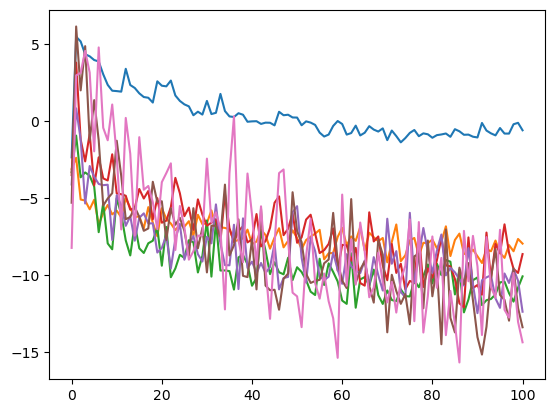

In [41]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["loss"][:,:,0])

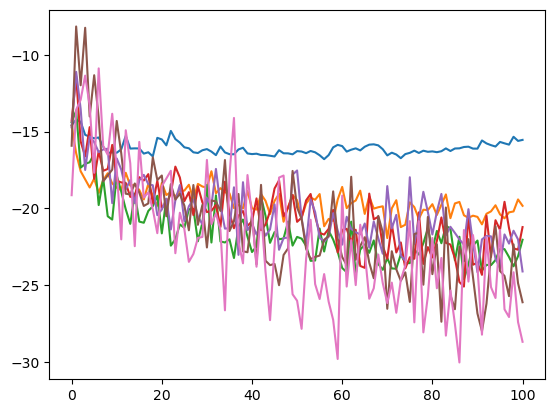

In [42]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["hsic_indep"][:,:,0])

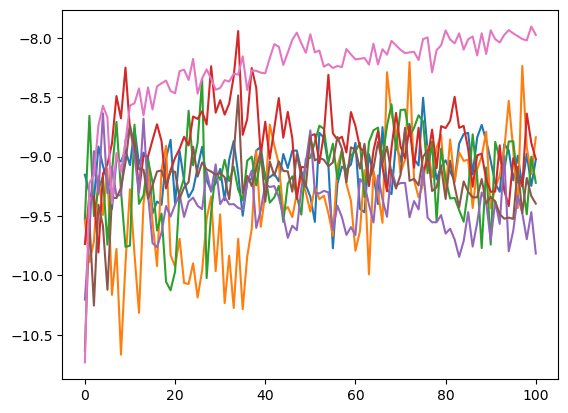

In [43]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["hsic_resids"][:,::,0])

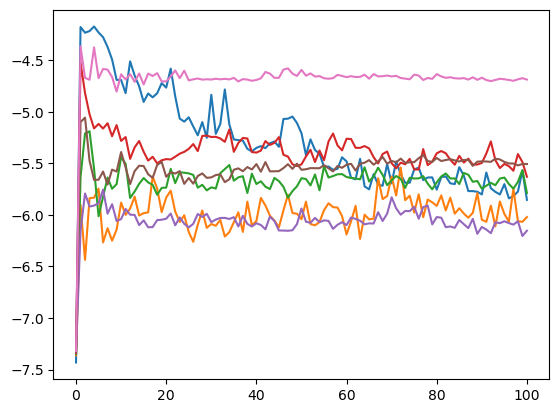

In [44]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["mses"][:,:,0])

## resids

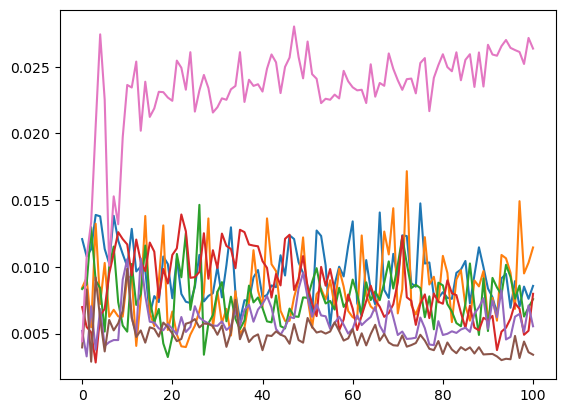

In [45]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["hsic_rx_ax"][:,:,0])

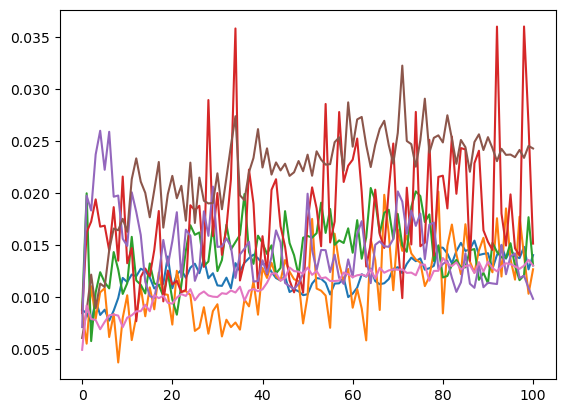

In [46]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["hsic_ry_ay"][:,:,0])

## indeps

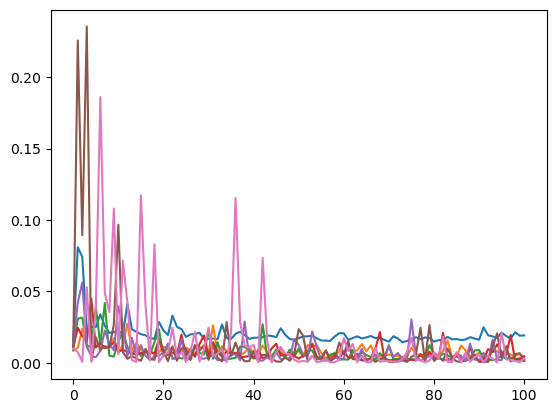

In [47]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["hsic_zx_zy"][:,:,0])

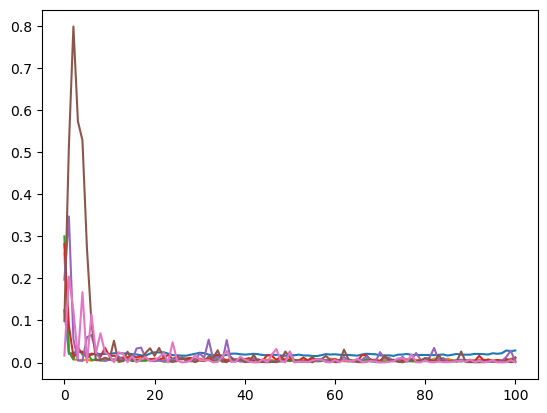

In [48]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["hsic_zx_zc"][:,:,0])

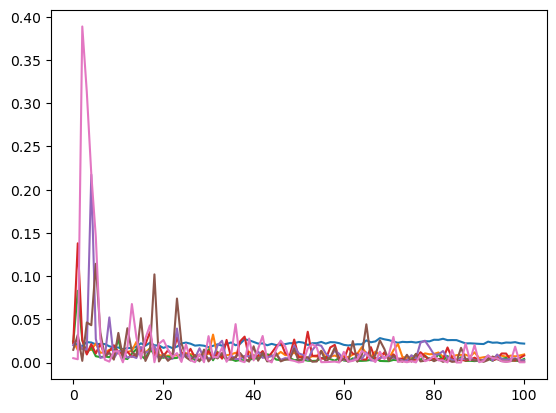

In [49]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["hsic_zy_zc"][:,:,0])

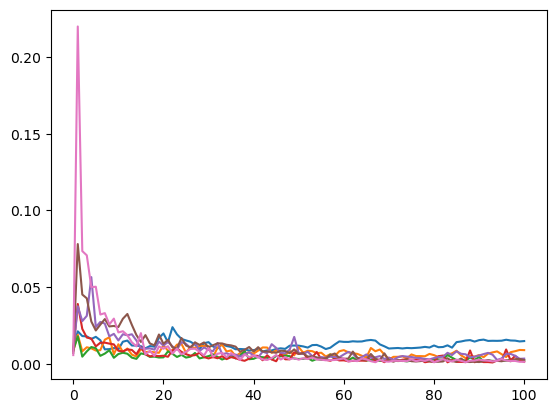

In [50]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["hsic_zy_x"][:,:,0])

# mses

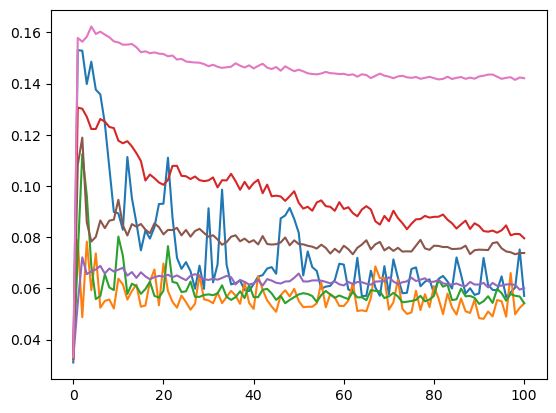

In [51]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["mse_rx"][:,:,0])

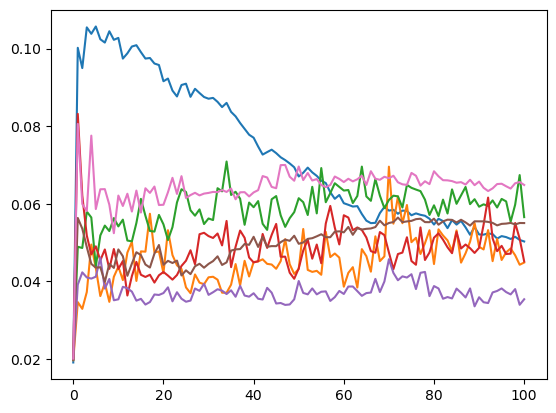

In [52]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["mse_ry"][:,:,0])

## zs vs z_est

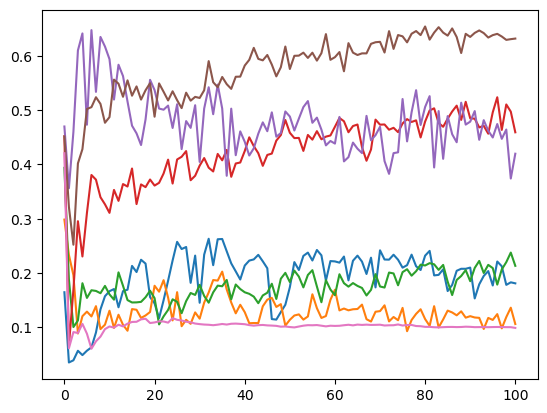

In [53]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["hsic_zx"][:,:,0])

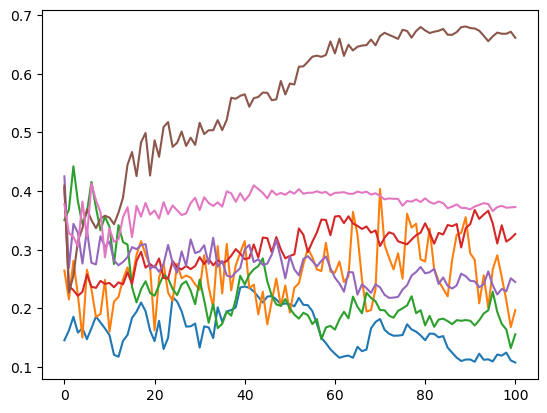

In [54]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["hsic_zy"][:,:,0])

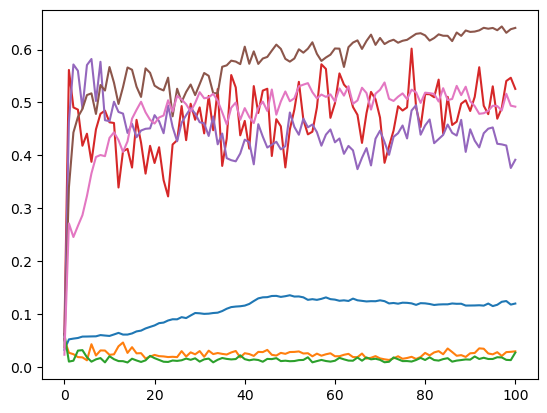

In [55]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["hsic_zc"][:,:,0])

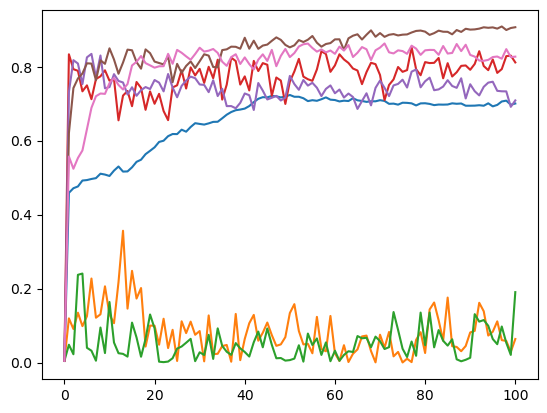

In [66]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["corr_zc"][:,:,0])

## zc in zx and zy 

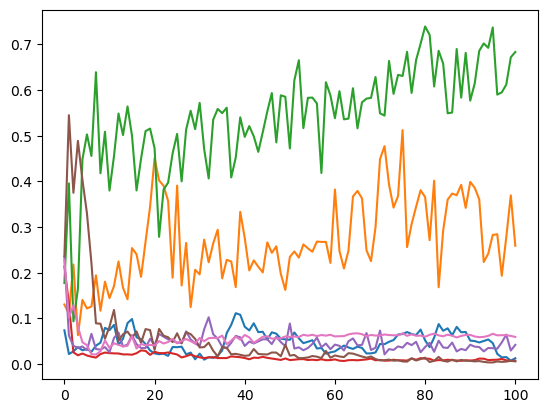

In [99]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["imp_zx"][:,0:7,0])

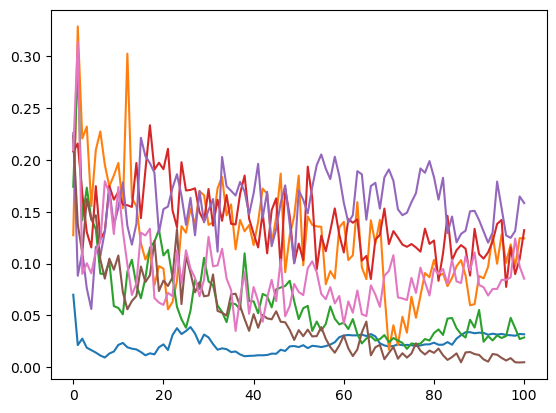

In [57]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["imp_zy"][:,:,0])

# hsic(x, zc), hsic(y, zc)

In [60]:
zx_real = Z[:,[7,1,2]]
zy_real = Z[:,[0,6,5]]
zc_real = Z[:,9]

In [62]:
hsicRBF(zc_real, x)

DeviceArray(0.164, dtype=float32)

In [63]:
hsicRBF(zc_real, y)

DeviceArray(0.166, dtype=float32)

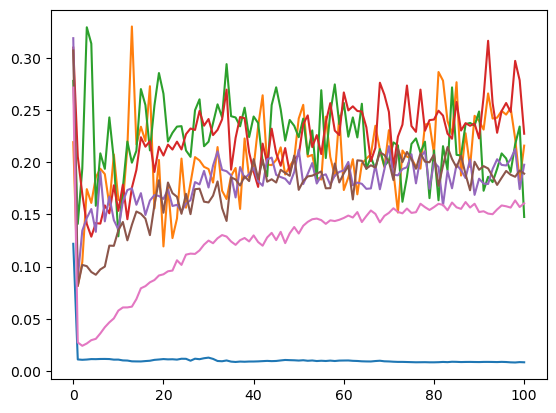

In [64]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["hsic_x_zc"][:,0:8,0])

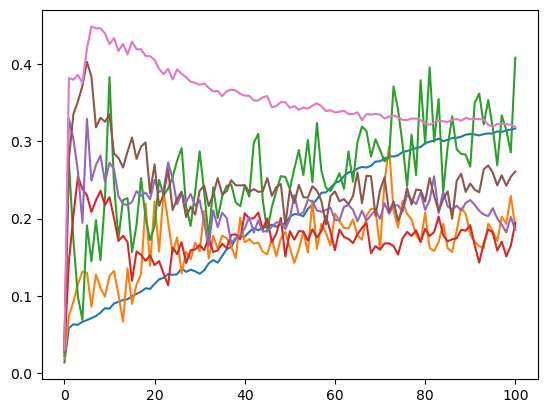

In [65]:
plt.plot(onp.arange(res["path"]["loss"].shape[0]),res["path"]["hsic_y_zc"][:,:,0])

## solution

In [67]:
params = res["params"] 

In [68]:
params["alpha_x"].shape

(1000, 7)

In [69]:
N = x.shape[0]
    

D_x = covariance_matrix(sqeuclidean_distance, x, x)
sigma_x_med = 1 / np.median(D_x)
K_x = rbf_kernel_matrix({'gamma': sigma_x_med}, x, x)

D_y = covariance_matrix(sqeuclidean_distance, y, y)
sigma_y = 1 / np.median(D_y)
K_y = rbf_kernel_matrix({'gamma': sigma_y}, y, y)
    
D_u = covariance_matrix(sqeuclidean_distance, U, U)
sigma_u = 1 / np.median(D_u)
K_u = rbf_kernel_matrix({'gamma': sigma_u}, U, U)

In [100]:
rep = 6
alpha_x = params["alpha_x"][:,rep][:,None]
alpha_y = params["alpha_y"][:,rep][:,None]
alpha_c = params["alpha_c"][:,rep][:,None]
    
zx = K_u@alpha_x
zy = K_u@alpha_y
zc = K_u@alpha_c
    
zx = (zx - np.mean(zx)) / (np.std(zx))
zy = (zy - np.mean(zy)) / (np.std(zy))
zc = (zc - np.mean(zc)) / (np.std(zc))

    
sig_x_h = np.exp(params["ln_sig_x_h"])
sig_zx_h = np.exp(params["ln_sig_zx_h"])
sig_zy_h = np.exp(params["ln_sig_zy_h"])
sig_zc_h = np.exp(params["ln_sig_zc_h"])
sig_rx_h = np.exp(params["ln_sig_rx_h"])
sig_ry_h = np.exp(params["ln_sig_ry_h"])
    


sig_x_f = np.exp(params["ln_sig_x_f"])
sig_zx_f = np.exp(params["ln_sig_zx_f"])
sig_zy_f = np.exp(params["ln_sig_zy_f"])
sig_zc_f = np.exp(params["ln_sig_zc_f"])
    
    
sigs_f = np.hstack([sig_x_f, sig_zx_f, sig_zy_f, sig_zc_f])
K_ax_f, K_ay_f, K_ax_h, K_ay_h, K_x_h, K_zx_h, K_zy_h, K_zc_h = kernel_mat_LNC(D_x, x, zx, zy, zc, sig_x_h, sig_zx_h, sig_zy_h, sig_zc_h, sigs_f) 
n = K_ax_f.shape[0]

ws = np.ones(n)
weights_y, resids_y, y_hat = krrModel(lam, K_ay_f, y, ws)
weights_x, resids_x, x_hat = krrModel(lam, K_ax_f, x, ws)

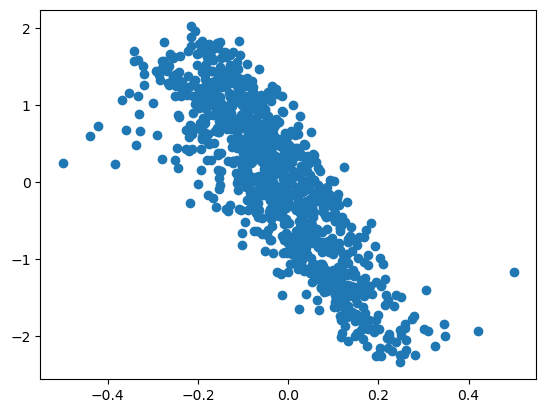

In [101]:
plt.scatter(zc_real, zc)

In [102]:
onp.abs(onp.corrcoef(zc_real, zc, rowvar=False)[0,1])

0.8271333218944972

In [103]:
(alpha_x*np.ones(7))[0:10,:]

DeviceArray([[-3.029, -3.029, -3.029, -3.029, -3.029, -3.029, -3.029],
             [ 0.8  ,  0.8  ,  0.8  ,  0.8  ,  0.8  ,  0.8  ,  0.8  ],
             [16.927, 16.927, 16.927, 16.927, 16.927, 16.927, 16.927],
             [-3.739, -3.739, -3.739, -3.739, -3.739, -3.739, -3.739],
             [-1.486, -1.486, -1.486, -1.486, -1.486, -1.486, -1.486],
             [ 1.576,  1.576,  1.576,  1.576,  1.576,  1.576,  1.576],
             [ 0.523,  0.523,  0.523,  0.523,  0.523,  0.523,  0.523],
             [-1.838, -1.838, -1.838, -1.838, -1.838, -1.838, -1.838],
             [-0.472, -0.472, -0.472, -0.472, -0.472, -0.472, -0.472],
             [-0.219, -0.219, -0.219, -0.219, -0.219, -0.219, -0.219]],            dtype=float32)

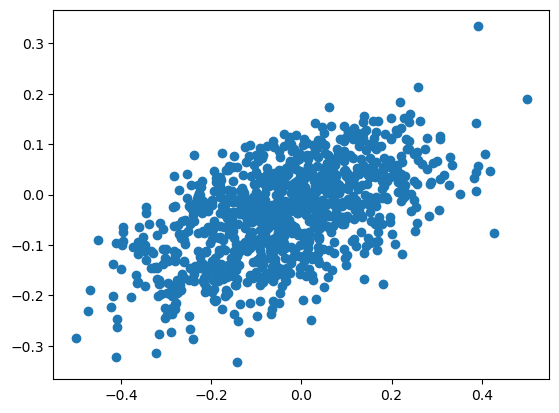

In [104]:
plt.scatter(x, x_hat)

In [105]:
_, _, xu_hat = krrModel(lam, K_u, x, ws)

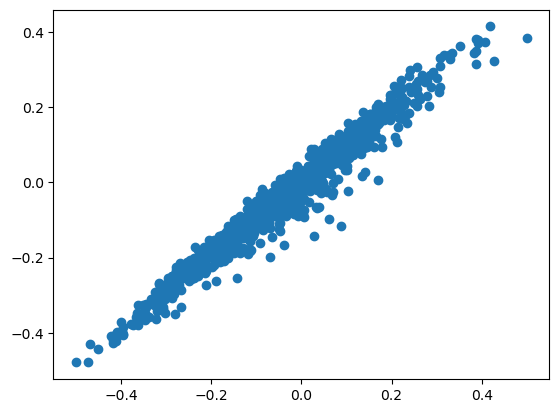

In [106]:
plt.scatter(x, xu_hat)

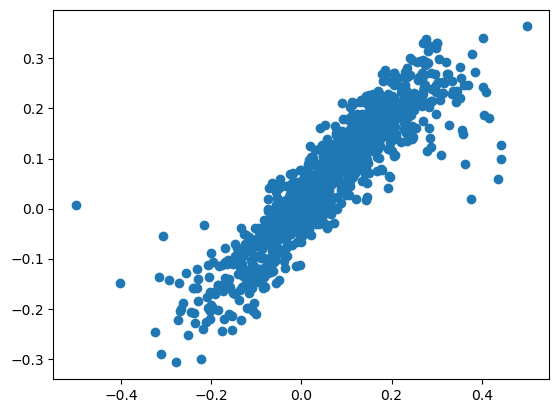

In [107]:
plt.scatter(y, y_hat)

In [108]:
onp.corrcoef(x=y, y=y_hat, rowvar=False)[0,0]

1.0

In [109]:
y_hat.shape

(1000, 1)

In [110]:
K_ayu_f  = K_x_h*K_u

In [111]:
weights_yu, resids_yu, yu_hat = krrModel(lam, K_ayu_f, y, ws)

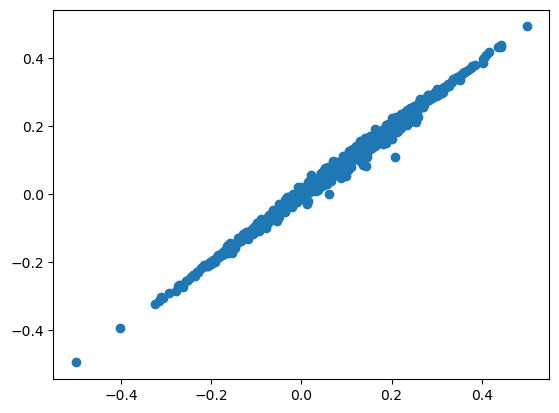

In [112]:
plt.scatter(y, yu_hat)

In [113]:

_, _, yx_hat = krrModel(lam, K_x_h, y, ws)

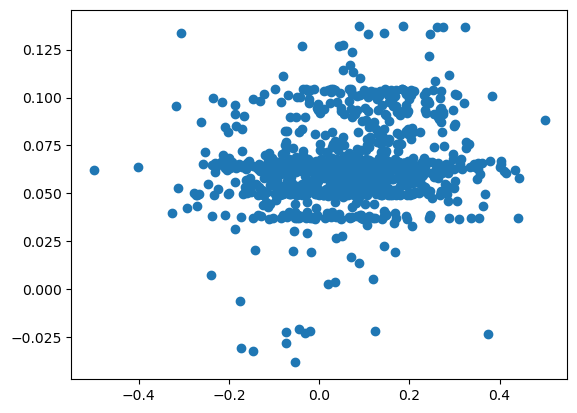

In [114]:
plt.scatter(y, yx_hat)

In [115]:
alpha_x = params["alpha_x"][:,rep][:,None]
alpha_y = params["alpha_y"][:,rep][:,None]
alpha_c = params["alpha_c"][:,rep][:,None]
    
zx = K_u@alpha_x
zy = K_u@alpha_y
zc = K_u@alpha_c

In [116]:
zx.shape

(1000, 1)

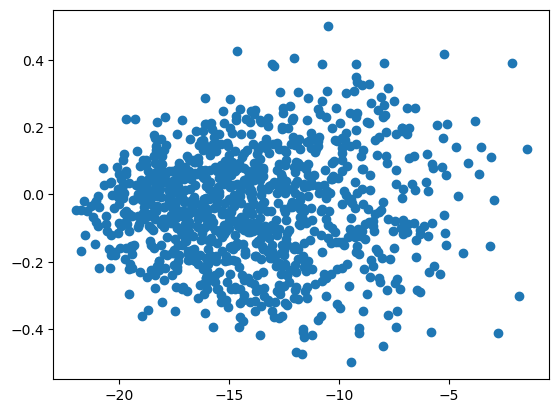

In [117]:
plt.scatter(zx, x)

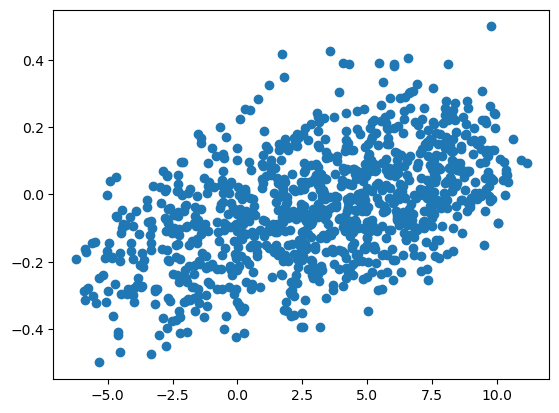

In [118]:
plt.scatter(zc, x)

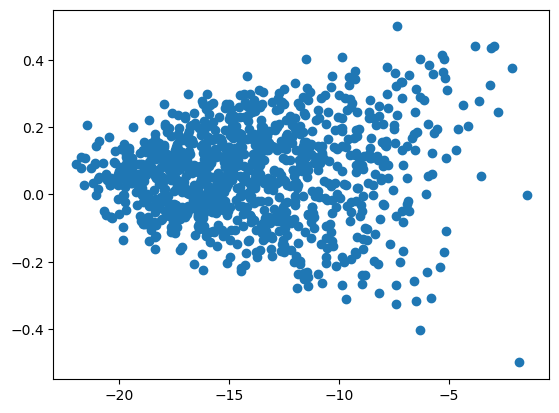

In [119]:
plt.scatter(zx, y)

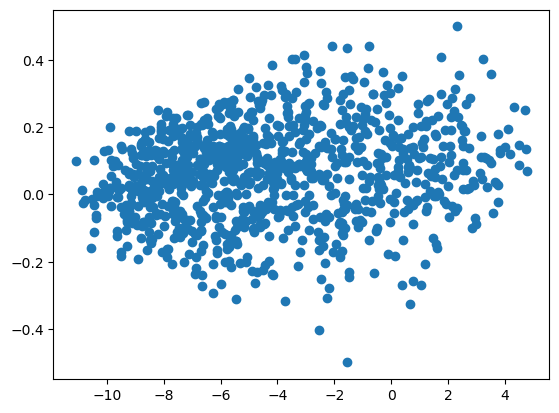

In [120]:
plt.scatter(zy, y)

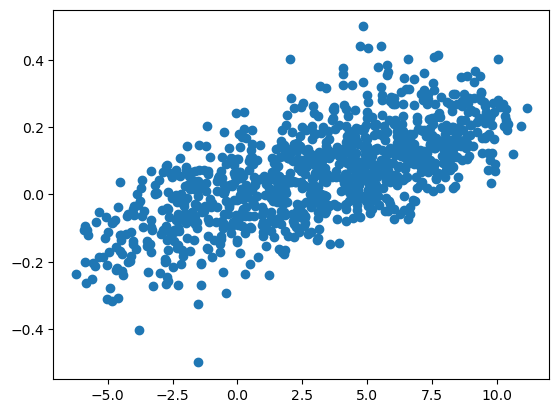

In [121]:
plt.scatter(zc, y)